# Mask R-CNN for Keypoint Detection

Example showing how to do keypoint detection with Mask R-CNN

In [1]:
USE_GPU = True
TRAIN   = True
RESTORE_PREVIOUS = True

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug
import time

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load COCO Datasets for Keypoint Detection

In [2]:
from coco import coco_keypoints
importlib.reload(coco_keypoints)

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare dataset
keypoints_to_include = ['nose', 'left_shoulder', 'right_shoulder',
                        'left_elbow', 'right_elbow', 'left_wrist',
                        'right_wrist', 'left_hip', 'right_hip',
                        'left_knee', 'right_knee', 'left_ankle',
                        'right_ankle']
#keypoints_to_include = ["nose", "right_wrist"]
keypoints_to_include = None

dataset_train = coco_keypoints.CocoDataset()
dataset_train.load_coco(COCO_DATA_DIR, subset="train", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_train.prepare()

dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_val.prepare()

Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=8.92s)
creating index...
index created!
Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


### Setup Training

In [3]:
class TrainConfig(Config):
    NAME = "coco_keypoints"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    GPU_COUNT = 1
    #MAX_GT_INSTANCES = 1
    
    # We use resnet50
    BACKBONE = "resnet50"
    
    # Set number of classes
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    
    # DEBUG:
    STEPS_PER_EPOCH = 1000 if USE_GPU else 10
    VALIDATION_STEPS = 50 if USE_GPU else 5
    
    TRAIN_ROIS_PER_IMAGE = 512
    
    RPN_NMS_THRESHOLD = 0.5
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
NAM

## Train

In [4]:
if TRAIN:
    importlib.reload(modellib)

    # Create model
    print("Creating model...")
    model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

    # Get path to saved weights
    try:
        if not RESTORE_PREVIOUS: raise Exception("")
        model_path = model.find_last()[1]
        
        # Load trained weights (fill in path to trained weights here)
        assert model_path != "", "Provide path to trained weights"
        print("Loading weights from ", model_path)
        model.load_weights(model_path, by_name=True)
    except:
        # Load weights trained on MS-COCO
        print("Starting from pretrained MS-COCO")
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

Creating model...

build:
input_gt_boxes.shape (?, ?, 4)
input_gt_kp_ids.shape (?, ?, 17)
input_gt_masks.shape (?, ?, 17)
target_mask.shape (2, ?, ?, ?)
target_mask.dtype <dtype: 'int32'>
mrcnn_mask.shape (?, 512, 17, 28, 28)
Loading weights from  /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180603T2004/mask_rcnn_coco_keypoints_0017.h5


In [ ]:
if TRAIN:
    importlib.reload(modellib)
    
    train_start_time = time.time()
    
    # Training - Stage 1
    print("Training network heads...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=40,
                layers="heads",
                augmentation=None)
    
    elapsed_time = time.time() - train_start_time
    print("Elapsed time %im %is" % (elapsed_time // 60, elapsed_time % 60))

Training network heads...

Starting at epoch 0. LR=0.001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180603T2004/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/40
 110/1000 [==>...........................] - ETA: 12:16 - loss: 8.3198 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.7383 - mrcnn_bbox_loss: 0.5728 - mrcnn_mask_loss: 6.9578

ERROR:root:Error processing image {'id': 426400, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000426400.jpg', 'width': 445, 'height': 640, 'annotations': [{'segmentation': [[113.65, 476.01, 101.45, 473.57, 105.84, 460.89, 114.62, 457.48, 110.72, 441.87, 110.72, 430.16, 117.06, 425.77, 135.6, 433.58, 150.72, 430.65, 163.4, 436.99, 152.67, 448.21, 147.3, 456.99, 139.99, 470.65, 136.57, 478.45, 130.72, 479.43, 124.87, 479.43], [109.26, 409.68, 110.23, 406.75, 115.11, 403.82, 123.4, 403.82, 126.33, 405.77, 132.18, 400.9, 130.23, 392.12, 130.23, 377.48, 133.65, 370.65, 145.84, 369.19, 154.13, 374.07, 157.55, 390.16, 159.5, 398.94, 164.86, 402.85, 176.57, 411.63, 176.08, 413.58, 159.5, 411.63, 130.23, 410.65]], 'num_keypoints': 17, 'area': 3230.40585, 'iscrowd': 0, 'keypoints': [143, 399, 2, 147, 395, 2, 139, 395, 2, 155, 394, 2, 134, 394, 2, 157, 405, 2, 132, 406, 2, 165, 407, 2, 123, 421, 1, 164, 407, 2, 120, 410, 2, 148, 436, 2, 133, 435, 2, 1

 936/1000 [===========================>..] - ETA: 50s - loss: 8.0937 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.7143 - mrcnn_bbox_loss: 0.4216 - mrcnn_mask_loss: 6.9106

ERROR:root:Error processing image {'id': 462837, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000462837.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[163.19, 213.89, 160.75, 211.2, 156.18, 211.04, 154.06, 212.67, 152.76, 216.42, 152.6, 219.27, 153.66, 220.49, 154.88, 221.31, 155.78, 222.61, 156.84, 223.67, 157.98, 224, 158.63, 225.79, 159.52, 226.93, 161.07, 227.42, 163.93, 227.26]], 'num_keypoints': 0, 'area': 134.4409, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 462837, 'bbox': [152.6, 211.04, 11.33, 16.38], 'category_id': 1, 'id': 203911}, {'segmentation': [[143.28, 222.13, 138.57, 222.62, 135.1, 226.97, 135.84, 230.94, 138.57, 233.04, 141.67, 234.41, 141.8, 232.05, 140.55, 227.21, 141.8, 225.1, 143.16, 223.99]], 'num_keypoints': 0, 'area': 58.00655, 'iscrowd': 0, 'k

 999/1000 [============================>.] - ETA: 0s - loss: 8.0871 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.7020 - mrcnn_bbox_loss: 0.4175 - mrcnn_mask_loss: 6.9207

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 838s 838ms/step - loss: 8.0868 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.7016 - mrcnn_bbox_loss: 0.4174 - mrcnn_mask_loss: 6.9209 - val_loss: 8.1272 - val_rpn_class_loss: 0.0380 - val_rpn_bbox_loss: 0.5746 - val_mrcnn_bbox_loss: 0.3763 - val_mrcnn_mask_loss: 7.1383
Epoch 2/40
 163/1000 [===>..........................] - ETA: 10:53 - loss: 7.9675 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.6242 - mrcnn_bbox_loss: 0.3678 - mrcnn_mask_loss: 6.9381

ERROR:root:Error processing image {'id': 461404, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000461404.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[139.88, 174.53, 136.3, 172.46, 141.39, 169.25, 141.01, 166.23, 138.94, 163.03, 137.24, 160.2, 136.3, 158.31, 131.02, 162.08, 129.32, 163.59, 123.66, 163.22, 117.25, 163.59, 114.98, 162.84, 114.23, 162.27, 111.02, 160.58, 110.46, 159.26, 111.96, 158.31, 116.49, 158.5, 123.66, 156.8, 128.56, 156.8, 134.41, 153.78, 136.3, 152.28, 135.73, 151.52, 133.09, 151.33, 133.09, 148.5, 133.66, 146.24, 131.58, 144.54, 135.17, 142.28, 138.56, 142.84, 141.2, 143.98, 141.39, 146.62, 141.58, 150.01, 144.41, 152.28, 148.56, 156.99, 152.33, 163.41, 153.84, 168.31, 153.65, 170.57, 149.69, 172.84, 145.35, 173.03]], 'num_keypoints': 0, 'area': 485.05345, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

 920/1000 [==========================>...] - ETA: 1:02 - loss: 8.0133 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.6173 - mrcnn_bbox_loss: 0.3561 - mrcnn_mask_loss: 7.0004

ERROR:root:Error processing image {'id': 336047, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000336047.jpg', 'width': 640, 'height': 434, 'annotations': [{'segmentation': [[31.14, 351.87, 33.35, 357.29, 31.34, 362.31, 26.32, 359.1, 25.31, 356.28, 26.52, 352.87, 26.52, 351.46, 27.92, 350.06, 30.53, 349.86, 31.54, 351.67]], 'num_keypoints': 0, 'area': 64.5222, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 336047, 'bbox': [25.31, 349.86, 8.04, 12.45], 'category_id': 1, 'id': 1206966}, {'segmentation': [[64.3, 356.94, 64.23, 354.57, 63.19, 349.91, 65.19, 349.24, 67.19, 353.61, 66.23, 357.61]], 'num_keypoints': 0, 'area': 20.1588, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

1000/1000 [==============================] - 826s 826ms/step - loss: 8.0210 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.6338 - mrcnn_bbox_loss: 0.3552 - mrcnn_mask_loss: 6.9924 - val_loss: 7.9431 - val_rpn_class_loss: 0.0361 - val_rpn_bbox_loss: 0.6151 - val_mrcnn_bbox_loss: 0.3126 - val_mrcnn_mask_loss: 6.9793
Epoch 3/40
   9/1000 [..............................] - ETA: 13:18 - loss: 8.2347 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.6519 - mrcnn_bbox_loss: 0.2637 - mrcnn_mask_loss: 7.2809

ERROR:root:Error processing image {'id': 536806, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000536806.jpg', 'width': 640, 'height': 481, 'annotations': [{'segmentation': [[364.74, 187.34, 359.64, 189.79, 358.88, 195.65, 354.73, 200.18, 350.95, 214.16, 350.2, 229.08, 350.38, 230.97, 366.82, 231.34, 367.57, 229.46, 369.27, 227, 370.32, 219.8, 369.51, 216.36, 369.18, 210.94, 369.18, 209.71, 366.97, 206.88, 365.43, 203.69, 364.14, 201.97, 366.29, 200.37, 368.19, 200.37, 369.18, 198.77, 369.29, 197.17, 369.52, 196.82, 370.58, 196.32, 369.96, 195.63, 370.03, 194.44, 370.03, 193.05, 370.03, 190.27, 369.26, 188.59, 367.8, 187.41, 365.85, 187.41]], 'num_keypoints': 0, 'area': 657.48295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 536806, 'bbox': [350.2, 187.34, 20.38, 44], 'category_id': 1, 'id': 192

  89/1000 [=>............................] - ETA: 11:58 - loss: 8.1237 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.6182 - mrcnn_bbox_loss: 0.3420 - mrcnn_mask_loss: 7.1204

ERROR:root:Error processing image {'id': 67018, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000067018.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[412.53, 333.55, 414.4, 333.82, 414.22, 337.12, 417.25, 338.63, 419.12, 341.22, 418.86, 346.03, 417.88, 347.28, 417.07, 348.08, 416.45, 352.36, 416.36, 353.34, 412.97, 353.97, 412.97, 352.54, 412.44, 352.63, 411.64, 353.52, 410.39, 353.34, 409.5, 353.25, 409.5, 351.11, 408.52, 350.4, 408.43, 348.35, 408.78, 347.19, 406.02, 344.87, 405.84, 342.29, 406.11, 340.32, 407.53, 338.45, 409.23, 337.03, 409.94, 336.22, 410.39, 333.91, 412.08, 333.1]], 'num_keypoints': 0, 'area': 179.7029, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 67018, 'bbox': [405.84, 333.1, 13.28, 20.87], 'category_id': 1, 'id': 498856}, {'segmentation': [[503.21

 756/1000 [=====================>........] - ETA: 3:12 - loss: 7.8946 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.6453 - mrcnn_bbox_loss: 0.3330 - mrcnn_mask_loss: 6.8774

In [ ]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 2
    # Finetune layers from ResNet stage 4 and up
    print("Fine tune Resnet stage 4 and up...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=120,
                layers="4+",
                augmentation=None)
    
    elapsed_time = time.time() - train_start_time
    print("Elapsed time %im %is" % (elapsed_time // 60, elapsed_time % 60))

Fine tune Resnet stage 4 and up...

Starting at epoch 2. LR=0.001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180603T2004/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_br

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'id': 574623, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000574623.jpg', 'width': 368, 'height': 640, 'annotations': [{'segmentation': [[19.58, 579.92, 19.64, 575.89, 20.52, 572.16, 20.17, 570.76, 19.17, 570.35, 19.17, 569.42, 18.59, 568.83, 17.83, 568.89, 17.31, 569.24, 17.31, 570.41, 17.54, 571.23, 17.25, 571.93, 16.78, 573.33, 16.78,

Epoch 3/120
 341/1000 [=========>....................] - ETA: 9:55 - loss: 8.0056 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.6794 - mrcnn_bbox_loss: 0.3442 - mrcnn_mask_loss: 6.9390

ERROR:root:Error processing image {'id': 166424, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000166424.jpg', 'width': 640, 'height': 482, 'annotations': [{'segmentation': [[225.41, 320.68, 227.65, 317.17, 231.17, 317.81, 239.49, 322.12, 242.68, 327.08, 244.6, 332.36, 244.28, 336.83, 241.24, 341.95, 240.92, 348.67, 244.76, 354.26, 251.32, 361.46, 253.88, 367.21, 257.23, 371.85, 261.71, 378.89, 264.75, 385.44, 264.91, 392.96, 262.83, 398.87, 259.31, 401.75, 254.84, 402.87, 254.04, 404.63, 254.2, 412.31, 254.84, 422.22, 253.08, 426.86, 253.88, 432.29, 255.95, 440.13, 256.27, 441.89, 255.32, 443.49, 255.32, 459.32, 251.96, 466.35, 251.64, 473.07, 251.16, 476.43, 249.24, 482, 207.19, 482, 206.87, 474.19, 209.26, 466.99, 213.74, 461.08, 214.54, 455.16, 211.02, 444.45, 212.78, 439.49, 212.78, 426.22, 208.14, 421.74, 210.06, 415.18, 210.54, 406.55, 209.74, 397.44, 208.14, 387.04, 207.99, 381.45, 205.27, 376.97, 206.39, 363.38, 209.1, 356.5, 212.62

 511/1000 [==============>...............] - ETA: 7:20 - loss: 7.9367 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.6633 - mrcnn_bbox_loss: 0.3374 - mrcnn_mask_loss: 6.8951

ERROR:root:Error processing image {'id': 425590, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000425590.jpg', 'width': 640, 'height': 428, 'annotations': [{'segmentation': [[200.36, 136.32, 245.57, 133.43, 266.73, 144.01, 284.04, 186.33, 285.96, 223.84, 276.34, 274.82, 253.26, 295.02, 250.38, 292.13, 267.69, 258.47, 277.31, 216.15, 277.31, 215.19, 257.11, 242.12, 235.95, 254.62, 221.52, 256.54, 208.06, 259.43, 196.51, 326.75, 183.05, 369.07, 175.36, 378.69, 171.51, 402.74, 175.36, 420.05, 165.74, 428, 3.19, 420.05, 0.31, 296.94, 21.47, 285.4, 26.28, 278.66, 30.12, 266.16, 57.05, 246.93, 87.83, 226.73, 103.22, 219.03, 136.88, 208.45, 147.46, 203.64, 153.23, 180.56, 180.16, 149.78, 195.55, 139.2]], 'num_keypoints': 4, 'area': 48411.53435, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 184, 165, 2, 0, 0, 0, 173, 237, 2, 84, 297, 2, 172, 354, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id'

 533/1000 [==============>...............] - ETA: 7:00 - loss: 7.9455 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.6620 - mrcnn_bbox_loss: 0.3339 - mrcnn_mask_loss: 6.9092

ERROR:root:Error processing image {'id': 47177, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000047177.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[279.51, 242.13, 281.35, 240.29, 281.16, 237.77, 280.73, 237.1, 279.51, 239.61, 278.95, 241.27]], 'num_keypoints': 0, 'area': 6.22615, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 47177, 'bbox': [278.95, 237.1, 2.4, 5.03], 'category_id': 1, 'id': 1677877}, {'segmentation': [[316.11, 222.61, 315.66, 223.52, 315.2, 224.32, 315.2, 225.34, 315.43, 226.37, 316.23, 226.82, 317.82, 227.05, 318.05, 225.69, 317.94, 225.12, 317.14, 224.55, 317.14, 224.2, 317.71, 222.61, 317.48, 222.27, 317.25, 222.27]], 'num_keypoints': 0, 'area': 9.54535, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

 999/1000 [============================>.] - ETA: 0s - loss: 7.8921 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.6232 - mrcnn_bbox_loss: 0.3286 - mrcnn_mask_loss: 6.9026

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 941s 941ms/step - loss: 7.8922 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.6229 - mrcnn_bbox_loss: 0.3285 - mrcnn_mask_loss: 6.9030 - val_loss: 7.5859 - val_rpn_class_loss: 0.0272 - val_rpn_bbox_loss: 0.4589 - val_mrcnn_bbox_loss: 0.2878 - val_mrcnn_mask_loss: 6.8121
Epoch 4/120
  60/1000 [>.............................] - ETA: 13:28 - loss: 8.0613 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.5595 - mrcnn_bbox_loss: 0.3227 - mrcnn_mask_loss: 7.1424

ERROR:root:Error processing image {'id': 67018, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000067018.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[412.53, 333.55, 414.4, 333.82, 414.22, 337.12, 417.25, 338.63, 419.12, 341.22, 418.86, 346.03, 417.88, 347.28, 417.07, 348.08, 416.45, 352.36, 416.36, 353.34, 412.97, 353.97, 412.97, 352.54, 412.44, 352.63, 411.64, 353.52, 410.39, 353.34, 409.5, 353.25, 409.5, 351.11, 408.52, 350.4, 408.43, 348.35, 408.78, 347.19, 406.02, 344.87, 405.84, 342.29, 406.11, 340.32, 407.53, 338.45, 409.23, 337.03, 409.94, 336.22, 410.39, 333.91, 412.08, 333.1]], 'num_keypoints': 0, 'area': 179.7029, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 67018, 'bbox': [405.84, 333.1, 13.28, 20.87], 'category_id': 1, 'id': 498856}, {'segmentation': [[503.21

 489/1000 [=============>................] - ETA: 7:16 - loss: 7.8760 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.5892 - mrcnn_bbox_loss: 0.3158 - mrcnn_mask_loss: 6.9350

ERROR:root:Error processing image {'id': 546211, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000546211.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[420.74, 182.67, 419.5, 170.59, 428.79, 156.65, 433.13, 150.45, 434.06, 149.21, 434.06, 143.02, 436.84, 136.51, 440.25, 135.27, 438.7, 128.77, 437.46, 119.48, 439.63, 115.76, 442.42, 112.35, 447.07, 111.42, 453.26, 113.9, 456.36, 115.45, 460.39, 119.17, 463.17, 126.6, 460.7, 134.03, 465.34, 134.96, 465.96, 140.85, 474.02, 142.09, 478.04, 142.71, 487.65, 153.55, 490.12, 158.51, 497.56, 159.74, 497.56, 163.46, 501.58, 164.7, 506.23, 167.18, 508.09, 173.68, 507.16, 176.16, 502.2, 177.4, 499.73, 179.26, 491.05, 178.95, 486.72, 173.68, 482.69, 172.13, 479.9, 168.42, 474.33, 166.56, 475.87, 171.82, 475.56, 175.85, 474.64, 178.02, 474.94, 183.29, 476.49, 190.1, 478.66, 192.27, 479.59, 197.23, 480.21, 202.18, 478.97, 204.66, 480.83, 208.07, 483.31, 209.62, 483.62, 212.4, 482.38,

 703/1000 [====================>.........] - ETA: 4:12 - loss: 7.8668 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.5969 - mrcnn_bbox_loss: 0.3124 - mrcnn_mask_loss: 6.9215

ERROR:root:Error processing image {'id': 134760, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000134760.jpg', 'width': 640, 'height': 484, 'annotations': [{'segmentation': [[330.72, 305.23, 331.94, 306.96, 333.77, 307.06, 333.77, 311.64, 333.26, 312.66, 334.59, 316.53, 332.96, 316.94, 331.43, 316.94, 331.22, 316.02, 330.21, 312.87, 329.9, 312.05, 328.68, 308.18, 330.21, 307.26, 329.49, 305.84]], 'num_keypoints': 0, 'area': 40.0667, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 134760, 'bbox': [328.68, 305.23, 5.91, 11.71], 'category_id': 1, 'id': 452904}, {'segmentation': [[511.12, 345.88, 515.38, 337.37, 518.93, 332.4, 537.37, 348.71, 542.33, 346.94, 531.69, 336.66, 526.73, 333.11, 524.6, 329.92, 524.25, 324.95, 524.25, 318.92, 529.21, 323.18, 530.27, 331.69, 531.69, 334.17, 533.82, 330.27, 533

 999/1000 [============================>.] - ETA: 0s - loss: 7.8748 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.6062 - mrcnn_bbox_loss: 0.3138 - mrcnn_mask_loss: 6.9183

ERROR:root:Error processing image {'id': 272148, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000272148.jpg', 'width': 640, 'height': 378, 'annotations': [{'segmentation': [[201.51, 256.72, 203.58, 256, 202.68, 254.11, 202.41, 252.32, 202.86, 251.24, 204.93, 250.43, 207.36, 250.97, 207.81, 253.49, 207.27, 255.55, 209.16, 255.73, 212.21, 258.25, 212.3, 259.51, 210.15, 261.31, 211.31, 262.75, 209.97, 263.02, 206.37, 264.27, 204.21, 261.76, 203.85, 260.77, 201.33, 264.18, 199.36, 263.47, 199.63, 261.67, 200.62, 260.5, 201.15, 259.51, 201.42, 257.98]], 'num_keypoints': 0, 'area': 99.6422, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 272148, 'bbox': [199.36, 250.43, 12.94, 13.84], 'category_id': 1, 'id': 476226}, {'segmentation': [[289.42, 265.31, 289.8, 262.46, 292.59, 262.33, 293.88, 263.63, 294.01,

1000/1000 [==============================] - 891s 891ms/step - loss: 7.8752 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.6061 - mrcnn_bbox_loss: 0.3139 - mrcnn_mask_loss: 6.9187 - val_loss: 7.2887 - val_rpn_class_loss: 0.0361 - val_rpn_bbox_loss: 0.5433 - val_mrcnn_bbox_loss: 0.3371 - val_mrcnn_mask_loss: 6.3721
Epoch 5/120
 415/1000 [===========>..................] - ETA: 8:19 - loss: 7.7257 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.5679 - mrcnn_bbox_loss: 0.3059 - mrcnn_mask_loss: 6.8164

ERROR:root:Error processing image {'id': 477398, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000477398.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[475.83, 368.88, 477.38, 370.24, 478.8, 370.68, 478.49, 375.99, 477.81, 380.75, 477.75, 382.05, 479.85, 380.19, 479.85, 377.84, 479.91, 375.87, 480.53, 375.25, 480.9, 377.53, 480.96, 380.75, 481.64, 381.06, 482.32, 378.15, 482.38, 375.25, 483, 373.52, 483.19, 369.07, 482.63, 367.96, 482.38, 365.79, 479.6, 365.73, 479.36, 367.21, 477.25, 368.51, 475.4, 367.52]], 'num_keypoints': 0, 'area': 61.6594, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 477398, 'bbox': [475.4, 365.73, 7.79, 16.32], 'category_id': 1, 'id': 484741}, {'segmentation': [[432.62, 378.56, 432.71, 375.16, 431.96, 372.91, 433.54, 371.83, 434.28, 371.92, 435.03, 

 493/1000 [=============>................] - ETA: 7:13 - loss: 7.6744 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.5621 - mrcnn_bbox_loss: 0.3062 - mrcnn_mask_loss: 6.7713

ERROR:root:Error processing image {'id': 166424, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000166424.jpg', 'width': 640, 'height': 482, 'annotations': [{'segmentation': [[225.41, 320.68, 227.65, 317.17, 231.17, 317.81, 239.49, 322.12, 242.68, 327.08, 244.6, 332.36, 244.28, 336.83, 241.24, 341.95, 240.92, 348.67, 244.76, 354.26, 251.32, 361.46, 253.88, 367.21, 257.23, 371.85, 261.71, 378.89, 264.75, 385.44, 264.91, 392.96, 262.83, 398.87, 259.31, 401.75, 254.84, 402.87, 254.04, 404.63, 254.2, 412.31, 254.84, 422.22, 253.08, 426.86, 253.88, 432.29, 255.95, 440.13, 256.27, 441.89, 255.32, 443.49, 255.32, 459.32, 251.96, 466.35, 251.64, 473.07, 251.16, 476.43, 249.24, 482, 207.19, 482, 206.87, 474.19, 209.26, 466.99, 213.74, 461.08, 214.54, 455.16, 211.02, 444.45, 212.78, 439.49, 212.78, 426.22, 208.14, 421.74, 210.06, 415.18, 210.54, 406.55, 209.74, 397.44, 208.14, 387.04, 207.99, 381.45, 205.27, 376.97, 206.39, 363.38, 209.1, 356.5, 212.62

 551/1000 [===============>..............] - ETA: 6:22 - loss: 7.6815 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.5692 - mrcnn_bbox_loss: 0.3082 - mrcnn_mask_loss: 6.7691

ERROR:root:Error processing image {'id': 231667, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000231667.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[209, 180.48, 204.99, 190.9, 202.59, 197.32, 196.98, 203.73, 188.16, 210.14, 179.34, 222.17, 174.53, 233.39, 172.93, 246.22, 168.12, 268.66, 167.32, 283.9, 165.71, 295.12, 164.91, 305.54, 168.12, 318.37, 172.13, 327.18, 173.73, 336, 172.93, 353.64, 172.93, 360.05, 171.32, 372.88, 167.32, 386.51, 164.91, 399.33, 162.51, 413.76, 161.7, 427.39, 160.1, 441.02, 162.51, 448.23, 167.32, 450.64, 180.94, 448.23, 188.96, 445.83, 190.56, 439.41, 184.95, 430.6, 181.75, 426.59, 184.15, 414.56, 186.56, 404.14, 188.96, 385.7, 192.97, 371.27, 196.18, 358.45, 198.58, 348.03, 199.38, 347.22, 205.8, 367.27, 204.19, 376.08, 205.8, 385.7, 208.2, 397.73, 209.8, 407.35, 209.8, 416.97, 211.41, 429.79, 222.63, 430.6, 230.65, 423.38, 247.48, 424.18, 250.69, 424.98, 251.49, 420.98, 248.28, 412.96,

 808/1000 [=======================>......] - ETA: 2:44 - loss: 7.7829 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.5806 - mrcnn_bbox_loss: 0.3041 - mrcnn_mask_loss: 6.8645

ERROR:root:Error processing image {'id': 550395, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000550395.jpg', 'width': 640, 'height': 429, 'annotations': [{'segmentation': [[114.87, 208.28, 112.35, 189.81, 105.22, 177.22, 98.08, 180.58, 101.02, 191.91, 98.5, 204.92, 94.72, 204.92, 93.05, 212.05, 90.95, 238.49, 98.5, 241.85, 98.5, 219.19, 113.19, 209.12]], 'num_keypoints': 0, 'area': 674.15505, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 550395, 'bbox': [90.95, 177.22, 23.92, 64.63], 'category_id': 1, 'id': 219384}, {'segmentation': [[312.44, 184.95, 313.99, 181.4, 311.51, 179.54, 311.21, 179.39, 310.9, 175.98, 313.99, 175.06, 316.62, 175.36, 318.16, 177.68, 318.32, 180.62, 320.02, 183.56, 319.87, 186.04, 320.02, 187.74, 319.71, 189.9, 319.56, 190.52, 316.77, 188.51]], 'num_keypoints': 0, 'area

 884/1000 [=========================>....] - ETA: 1:39 - loss: 7.7897 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.5717 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 6.8810

ERROR:root:Error processing image {'id': 250067, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000250067.jpg', 'width': 640, 'height': 640, 'annotations': [{'segmentation': [[456.42, 515.56, 457.52, 515.56, 459.98, 513.92, 461.34, 511.19, 459.98, 501.9, 460.79, 497.81, 462.98, 494.8, 467.08, 492.62, 474.45, 492.34, 476.09, 496.71, 480.18, 501.36, 482.92, 506.54, 483.46, 512.55, 483.46, 517.2, 483.19, 521.29, 482.92, 538.5, 483.19, 552.15, 478.27, 553.52, 482.64, 584.65, 472.62, 585.87, 468.07, 583.8, 468.89, 581.32, 470.14, 577.59, 473.86, 574.28, 470.96, 558.55, 461.44, 553.17, 461.44, 552.76, 462.27, 546.96, 463.51, 534.96, 463.51, 523.78, 460.2, 525.44, 458.54, 523.37, 456.06, 525.02, 455.65, 521.71, 456.47, 516.33]], 'num_keypoints': 11, 'area': 1583.67655, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 462, 503, 2, 0, 0, 0, 466, 511, 2, 479, 508, 2, 459, 520, 2, 0, 0, 0, 459, 515, 2, 0, 0, 0, 467, 533, 2, 476, 532, 2, 475, 564, 

 906/1000 [==========================>...] - ETA: 1:20 - loss: 7.7819 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.5710 - mrcnn_bbox_loss: 0.3034 - mrcnn_mask_loss: 6.8739

ERROR:root:Error processing image {'id': 438629, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000438629.jpg', 'width': 640, 'height': 640, 'annotations': [{'segmentation': [[475.04, 485.55, 475.04, 474.52, 471.03, 473.26, 472.29, 465.99, 472.29, 460.73, 475.8, 458.22, 476.05, 456.21, 476.8, 453.96, 479.56, 453.96, 480.06, 455.71, 479.06, 457.72, 478.55, 458.72, 478.3, 459.98, 481.56, 461.23, 482.32, 463.24, 482.32, 466.24, 482.32, 466.24, 481.16, 469.07, 480.9, 470.18, 482.09, 471.28, 482.52, 472.73, 482.52, 474.34, 481.24, 474.68, 479.2, 474.26, 478.35, 474.51, 479.73, 479.96, 479.51, 485.05, 481.21, 485.69, 479.51, 486.33, 477.82, 486.12, 475.91, 486.12, 473.78, 486.12, 474.88, 485.83]], 'num_keypoints': 0, 'area': 214.2106, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 438629, 'bbox': [471.03

 999/1000 [============================>.] - ETA: 0s - loss: 7.7620 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.5726 - mrcnn_bbox_loss: 0.3042 - mrcnn_mask_loss: 6.8514

ERROR:root:Error processing image {'id': 384666, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000384666.jpg', 'width': 500, 'height': 332, 'annotations': [{'segmentation': [[172.51, 190.23, 177.71, 183.41, 181.6, 177.89, 184.85, 172.04, 187.12, 165.54, 189.72, 164.57, 194.27, 160.02, 198.49, 157.75, 200.76, 154.18, 200.11, 146.06, 200.76, 140.86, 205.63, 138.27, 210.83, 137.29, 217.98, 142.49, 217.98, 150.28, 216.03, 155.8, 218.3, 159.05, 220.25, 166.19, 223.17, 173.99, 225.44, 180.16, 228.04, 187.63, 229.67, 192.5, 235.19, 192.82, 235.84, 196.4, 234.54, 202.57, 232.26, 202.57, 226.74, 196.72, 223.5, 193.15, 217.33, 191.2, 217.33, 193.15, 219.92, 199.32, 219.92, 210.03, 220.25, 213.93, 223.5, 221.4, 222.52, 230.49, 222.2, 237.64, 220.25, 242.18, 217.98, 245.43, 213.43, 239.91, 212.45, 229.52, 211.8, 219.13, 209.53, 208.41, 205.63, 202.57, 202.06, 211.01, 201.09, 218.15, 195.24, 225.62, 193.94, 233.09, 190.7, 239.26, 184.53, 242.83, 180.3, 240

1000/1000 [==============================] - 900s 900ms/step - loss: 7.7622 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.5723 - mrcnn_bbox_loss: 0.3042 - mrcnn_mask_loss: 6.8519 - val_loss: 8.0980 - val_rpn_class_loss: 0.0377 - val_rpn_bbox_loss: 0.6218 - val_mrcnn_bbox_loss: 0.3047 - val_mrcnn_mask_loss: 7.1338
Epoch 6/120
 219/1000 [=====>........................] - ETA: 11:11 - loss: 7.8238 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.6146 - mrcnn_bbox_loss: 0.3108 - mrcnn_mask_loss: 6.8649

ERROR:root:Error processing image {'id': 441433, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000441433.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[457.48, 170.86, 446.06, 169.82, 448.48, 165.32, 450.73, 157.71, 453.15, 150.78, 453.5, 144.21, 456.79, 122.75, 461.11, 117.21, 464.05, 110.29, 467.34, 109.25, 471.67, 112.71, 470.11, 116.35, 467.34, 116, 465.96, 119.98, 461.98, 127.77, 465.26, 127.25, 466.3, 129.84, 466.48, 132.44, 461.8, 130.36, 461.46, 135.9, 462.5, 139.88, 459.9, 143.17, 459.73, 147.84, 460.8, 151.66, 462.64, 161.47, 461.61, 171.89, 460.39, 171.49, 460.18, 156.57, 459.16, 154.93, 454.46, 160.65, 452.62, 165.56, 454.87, 169.03, 457.94, 169.24]], 'num_keypoints': 0, 'area': 458.6233, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 441433, 'bbox': [446.06, 109

 734/1000 [=====================>........] - ETA: 3:50 - loss: 7.7580 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.5293 - mrcnn_bbox_loss: 0.2970 - mrcnn_mask_loss: 6.9009

ERROR:root:Error processing image {'id': 254301, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000254301.jpg', 'width': 640, 'height': 327, 'annotations': [{'segmentation': [[166.71, 320.76, 166.36, 326.97, 156.62, 326.91, 155.28, 318.27, 155.81, 314.67, 152.91, 313.98, 153.14, 312.06, 157.72, 309.1, 157.08, 307.36, 157.66, 304.7, 159.98, 304.46, 161.9, 305.97, 161.72, 308.06, 160.91, 309.1, 163.46, 309.28, 165.14, 311.08, 166.42, 312.24, 166.07, 313.28, 162.71, 313.22, 162.88, 316.01, 164.91, 316.01, 165.9, 319.2, 166.59, 320.47]], 'num_keypoints': 0, 'area': 196.6758, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 254301, 'bbox': [152.91, 304.46, 13.8, 22.51], 'category_id': 1, 'id': 187396}, {'segmentation': [[103.71, 276.86, 102.24, 280.16, 100.77, 280.26, 100.04, 278.69, 101.23, 276.49, 101.9

 942/1000 [===========================>..] - ETA: 50s - loss: 7.7520 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.5432 - mrcnn_bbox_loss: 0.2973 - mrcnn_mask_loss: 6.8796

ERROR:root:Error processing image {'id': 39137, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000039137.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[181.21, 133.75, 197.39, 127.28, 228.67, 129.44, 245.93, 131.6, 254.56, 145.62, 256.72, 170.43, 261.03, 185.53, 271.82, 195.24, 291.24, 209.26, 313.89, 225.44, 324.67, 228.67, 357.03, 225.44, 369.98, 220.04, 387.24, 223.28, 408.81, 232.99, 420.67, 239.46, 449.8, 239.46, 456.27, 239.46, 473.53, 244.85, 489.71, 257.8, 499.42, 262.11, 502.65, 273.98, 494.02, 278.29, 461.66, 280.45, 413.12, 282.61, 378.61, 282.61, 350.56, 279.37, 335.46, 280.45, 344.09, 295.55, 327.91, 305.26, 280.45, 300.94, 232.99, 299.87, 212.49, 304.18, 192, 300.94, 185.53, 297.71, 195.24, 289.08, 206.02, 284.76, 201.71, 282.61, 151.01, 291.24, 119.73, 295.55, 113.26, 286.92, 133.75, 284.76, 158.56, 277.21, 186.61, 272.9, 197.39, 267.51, 207.1, 262.11, 215.73, 248.09, 217.89, 228.67, 217.89, 221.12, 209.2

 999/1000 [============================>.] - ETA: 0s - loss: 7.7546 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.5472 - mrcnn_bbox_loss: 0.2973 - mrcnn_mask_loss: 6.8783

ERROR:root:Error processing image {'id': 421060, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000421060.jpg', 'width': 640, 'height': 418, 'annotations': [{'segmentation': [[139.61, 259.01, 155.1, 252.27, 182.71, 209.84, 168.56, 216.58, 167.89, 204.45, 175.97, 197.05, 192.81, 181.56, 217.05, 172.8, 249.38, 163.37, 256.12, 149.9, 268.91, 149.9, 279.69, 157.98, 281.04, 165.39, 274.97, 177.51, 289.12, 194.35, 291.81, 222.64, 283.73, 250.92, 261.5, 272.47, 246.69, 267.09, 252.75, 254.29, 243.32, 261.03, 229.18, 262.37, 215.71, 248.9, 210.99, 261.7, 204.93, 271.8, 192.81, 275.17, 177.32, 263.72, 177.32, 277.19]], 'num_keypoints': 12, 'area': 11417.7497, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 243, 172, 2, 285, 202, 2, 203, 186, 2, 279, 238, 2, 180, 201, 2, 261, 258, 2, 219, 224, 2, 237, 244, 2, 190, 217, 2, 209, 240, 2, 163, 259, 2, 195, 261, 2], 'image_id': 421060, 'bbox': [139.61, 149.9, 152.2, 127.29], 'category

1000/1000 [==============================] - 905s 905ms/step - loss: 7.7545 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.5467 - mrcnn_bbox_loss: 0.2971 - mrcnn_mask_loss: 6.8787 - val_loss: 8.0184 - val_rpn_class_loss: 0.0295 - val_rpn_bbox_loss: 0.4443 - val_mrcnn_bbox_loss: 0.2996 - val_mrcnn_mask_loss: 7.2450
Epoch 7/120
 674/1000 [===================>..........] - ETA: 4:40 - loss: 7.7262 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.5444 - mrcnn_bbox_loss: 0.2886 - mrcnn_mask_loss: 6.8625

ERROR:root:Error processing image {'id': 381851, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000381851.jpg', 'width': 640, 'height': 424, 'annotations': [{'segmentation': [[531.32, 145.96, 528.42, 145.7, 528.16, 145.29, 528.57, 144.92, 529.97, 144.77, 530.91, 139.9, 532, 139.17, 532.83, 137.93, 533.19, 137.25, 532.9, 134.02, 531.91, 133.81, 531.17, 133.95, 531.01, 134.71, 530.51, 135.31, 529.5, 134.99, 529.09, 134.25, 529.34, 133.33, 530.1, 132.8, 530.91, 132.64, 531.53, 132.07, 532.83, 131.7, 533.61, 131.2, 533.51, 130.79, 533.76, 129.16, 534.62, 128.15, 535.58, 127.98, 536.41, 128.45, 537.14, 129.01, 537.39, 129.79, 537.05, 130.32, 536.8, 130.67, 537.27, 130.9, 537.75, 131.24, 538.42, 131.45, 538.37, 131.86, 540.96, 131.65, 541.45, 131.13, 541.82, 130.62, 542.52, 130.72, 542.97, 131.18, 542.78, 131.72, 542.62, 132.07, 542.31, 132.53, 542.05, 133.05, 541.47, 133.39, 540.81, 133.31, 540.14, 133.36, 539.88, 133.57, 539.41, 133.78, 538.84, 1

 999/1000 [============================>.] - ETA: 0s - loss: 7.7318 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.5532 - mrcnn_bbox_loss: 0.2905 - mrcnn_mask_loss: 6.8571

ERROR:root:Error processing image {'id': 143068, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000143068.jpg', 'width': 640, 'height': 213, 'annotations': [{'segmentation': [[535.89, 209.44, 542.49, 178.81, 542.49, 164.67, 537.3, 165.14, 533.06, 155.71, 536.36, 151.94, 541.54, 148.64, 543.9, 148.17, 544.84, 140.16, 546.26, 130.73, 551.91, 128.84, 561.34, 133.09, 565.11, 140.63, 564.64, 146.28, 569.82, 150.05, 573.12, 162.31, 581.61, 176.92, 569.82, 175.51, 574.54, 193.42, 573.12, 208.03, 566.52, 209.44, 559.45, 208.5, 554.27, 203.31, 545.78, 211.8]], 'num_keypoints': 7, 'area': 2409.64295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 559, 138, 2, 542, 151, 2, 569, 151, 2, 540, 167, 1, 573, 166, 2, 0, 0, 0, 0, 0, 0, 543, 195, 2, 568, 195, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 143068, 'bbox': [533.06, 128.84, 48.55, 82.96], 'category_id': 1, 'id': 430155}, {'segmentation': [[527.01, 132.97, 527.01, 132.97, 529.01

1000/1000 [==============================] - 901s 901ms/step - loss: 7.7328 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.5537 - mrcnn_bbox_loss: 0.2906 - mrcnn_mask_loss: 6.8575 - val_loss: 7.9590 - val_rpn_class_loss: 0.0311 - val_rpn_bbox_loss: 0.5400 - val_mrcnn_bbox_loss: 0.2981 - val_mrcnn_mask_loss: 7.0897
Epoch 8/120
 206/1000 [=====>........................] - ETA: 11:20 - loss: 7.7139 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.5056 - mrcnn_bbox_loss: 0.2998 - mrcnn_mask_loss: 6.8766

ERROR:root:Error processing image {'id': 72650, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000072650.jpg', 'width': 640, 'height': 424, 'annotations': [{'segmentation': [[147.27, 293.12, 144.78, 284.02, 148.51, 272.85, 156.37, 268.71, 152.65, 260.43, 158.85, 251.74, 166.71, 254.64, 168.37, 257.54, 167.13, 269.95, 165.06, 276.99, 170.85, 280.71, 174.16, 301.4, 181.61, 323.75, 176.23, 329.13, 172.92, 326.23, 174.58, 322.09, 162.16, 292.71, 148.09, 292.71], [156.37, 322.09, 153.06, 341.54, 155.96, 369.26, 159.68, 373.4, 177.06, 373.82, 177.89, 371.33, 166.3, 363.47, 167.54, 343.61, 172.09, 325.4]], 'num_keypoints': 11, 'area': 1727.9653, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 164, 266, 2, 150, 277, 2, 165, 285, 2, 0, 0, 0, 170, 301, 2, 0, 0, 0, 176, 317, 2, 158, 313, 1, 166, 314, 1, 157, 337, 2, 164, 339, 2, 158, 363, 2, 162, 364, 2], 'image_id': 72650, 'bbox': [144.78, 251.74, 36.83, 122.08], 'category_id': 1, 'id':

 419/1000 [===========>..................] - ETA: 8:26 - loss: 7.8434 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.5351 - mrcnn_bbox_loss: 0.2964 - mrcnn_mask_loss: 6.9796

ERROR:root:Error processing image {'id': 154346, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000154346.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[382.28, 291.14, 383.08, 289.88, 383.65, 289.53, 384.11, 288.96, 384.46, 287.92, 385.83, 286.89, 387.44, 287.35, 387.9, 289.19, 387.56, 290.33, 389.51, 293.09, 388.36, 295.5, 388.02, 297.57, 387.67, 302.27, 386.87, 305.03, 385.15, 305.14, 382.85, 305.26, 382.39, 298.14, 382.97, 295.96, 382.28, 293.66, 382.16, 293.32, 381.82, 291.83]], 'num_keypoints': 0, 'area': 93.90755, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 154346, 'bbox': [381.82, 286.89, 7.69, 18.37], 'category_id': 1, 'id': 213040}, {'segmentation': [[406.85, 300.92, 407.01, 305.42, 405.52, 305.59, 406.01, 301.76, 404.18, 301.76, 404.02, 299.92, 404.18, 298.59, 4

 486/1000 [=============>................] - ETA: 7:30 - loss: 7.8294 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.5461 - mrcnn_bbox_loss: 0.2933 - mrcnn_mask_loss: 6.9577

ERROR:root:Error processing image {'id': 202582, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000202582.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[597.61, 234.84, 598.09, 225.91, 605.33, 225.67, 611.61, 225.91, 615.71, 220.6, 616.68, 212.64, 613.78, 207.33, 610.64, 204.19, 607.99, 205.88, 605.82, 210.95, 609.68, 212.16, 607.75, 216.74, 605.58, 221.33, 595.92, 217.47, 593.27, 231.47, 590.37, 236.05, 589.65, 237.5, 593.99, 236.05, 597.61, 233.64]], 'num_keypoints': 0, 'area': 280.60025, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 202582, 'bbox': [589.65, 204.19, 27.03, 33.31], 'category_id': 1, 'id': 199488}, {'segmentation': [[527.95, 217.91, 526.72, 214.63, 528.16, 211.56, 531.02, 209.72, 532.25, 209.51, 533.69, 210.13, 534.1, 211.15, 534.3, 213.2, 534.71, 213.81, 53

 595/1000 [================>.............] - ETA: 5:56 - loss: 7.8264 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.5506 - mrcnn_bbox_loss: 0.2941 - mrcnn_mask_loss: 6.9493

ERROR:root:Error processing image {'id': 210849, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000210849.jpg', 'width': 640, 'height': 500, 'annotations': [{'segmentation': [[389.72, 334.02, 391.47, 334.02, 392.89, 335.88, 393, 338.07, 393.55, 339.27, 395.3, 340.81, 396.07, 343.21, 396.07, 346.39, 395.41, 349.89, 394.42, 354.92, 395.3, 358.97, 395.19, 362.04, 394.42, 362.25, 393.99, 361.82, 391.36, 361.82, 390.81, 360.61, 389.72, 357.11, 389.61, 355.25, 389.94, 351.31, 389.94, 348.9, 389.94, 346.06, 389.94, 343.21, 388.95, 342.56, 388.08, 339.49, 387.42, 335.88, 388.73, 334.02, 389.06, 333.91]], 'num_keypoints': 0, 'area': 150.42635, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 210849, 'bbox': [387.42, 333.91, 8.65, 28.34], 'category_id': 1, 'id': 201659}, {'segmentation': [[465.47, 407.39, 462.

1000/1000 [==============================] - 923s 923ms/step - loss: 7.8053 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.5570 - mrcnn_bbox_loss: 0.2913 - mrcnn_mask_loss: 6.9252 - val_loss: 7.5458 - val_rpn_class_loss: 0.0291 - val_rpn_bbox_loss: 0.5774 - val_mrcnn_bbox_loss: 0.2866 - val_mrcnn_mask_loss: 6.6527
Epoch 9/120
 247/1000 [======>.......................] - ETA: 10:38 - loss: 7.6717 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.5497 - mrcnn_bbox_loss: 0.2868 - mrcnn_mask_loss: 6.8047

ERROR:root:Error processing image {'id': 504034, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000504034.jpg', 'width': 375, 'height': 500, 'annotations': [{'segmentation': [[141.66, 266.2, 141.85, 265, 143.14, 264.44, 144.34, 265.27, 144.25, 266.75, 145.36, 266.94, 145.18, 269.53, 146.1, 270.08, 146.1, 271.01, 145.64, 271.65, 144.53, 270.91, 144.16, 271.93, 144.99, 273.32, 144.99, 278.03, 143.97, 278.03, 143.42, 275.81, 143.05, 275.17, 142.4, 276.09, 142.68, 277.66, 140.55, 277.85, 140.74, 275.07, 140.92, 272.12, 140.65, 271.56, 139.44, 271.28, 139.54, 267.86, 140.74, 267.68, 140.74, 266.57, 141.29, 266.38]], 'num_keypoints': 0, 'area': 55.8566, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 504034, 'bbox': [139.44, 264.44, 6.66, 13.59], 'category_id': 1, 'id': 428329}, {'segmentation': [[260.63,

 338/1000 [=========>....................] - ETA: 9:20 - loss: 7.6707 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.5604 - mrcnn_bbox_loss: 0.2886 - mrcnn_mask_loss: 6.7907

ERROR:root:Error processing image {'id': 72650, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000072650.jpg', 'width': 640, 'height': 424, 'annotations': [{'segmentation': [[147.27, 293.12, 144.78, 284.02, 148.51, 272.85, 156.37, 268.71, 152.65, 260.43, 158.85, 251.74, 166.71, 254.64, 168.37, 257.54, 167.13, 269.95, 165.06, 276.99, 170.85, 280.71, 174.16, 301.4, 181.61, 323.75, 176.23, 329.13, 172.92, 326.23, 174.58, 322.09, 162.16, 292.71, 148.09, 292.71], [156.37, 322.09, 153.06, 341.54, 155.96, 369.26, 159.68, 373.4, 177.06, 373.82, 177.89, 371.33, 166.3, 363.47, 167.54, 343.61, 172.09, 325.4]], 'num_keypoints': 11, 'area': 1727.9653, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 164, 266, 2, 150, 277, 2, 165, 285, 2, 0, 0, 0, 170, 301, 2, 0, 0, 0, 176, 317, 2, 158, 313, 1, 166, 314, 1, 157, 337, 2, 164, 339, 2, 158, 363, 2, 162, 364, 2], 'image_id': 72650, 'bbox': [144.78, 251.74, 36.83, 122.08], 'category_id': 1, 'id':

 551/1000 [===============>..............] - ETA: 6:20 - loss: 7.6924 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.5477 - mrcnn_bbox_loss: 0.2823 - mrcnn_mask_loss: 6.8323

ERROR:root:Error processing image {'id': 438629, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000438629.jpg', 'width': 640, 'height': 640, 'annotations': [{'segmentation': [[475.04, 485.55, 475.04, 474.52, 471.03, 473.26, 472.29, 465.99, 472.29, 460.73, 475.8, 458.22, 476.05, 456.21, 476.8, 453.96, 479.56, 453.96, 480.06, 455.71, 479.06, 457.72, 478.55, 458.72, 478.3, 459.98, 481.56, 461.23, 482.32, 463.24, 482.32, 466.24, 482.32, 466.24, 481.16, 469.07, 480.9, 470.18, 482.09, 471.28, 482.52, 472.73, 482.52, 474.34, 481.24, 474.68, 479.2, 474.26, 478.35, 474.51, 479.73, 479.96, 479.51, 485.05, 481.21, 485.69, 479.51, 486.33, 477.82, 486.12, 475.91, 486.12, 473.78, 486.12, 474.88, 485.83]], 'num_keypoints': 0, 'area': 214.2106, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 438629, 'bbox': [471.03

1000/1000 [==============================] - 889s 889ms/step - loss: 7.7067 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.5460 - mrcnn_bbox_loss: 0.2837 - mrcnn_mask_loss: 6.8472 - val_loss: 7.2531 - val_rpn_class_loss: 0.0258 - val_rpn_bbox_loss: 0.4214 - val_mrcnn_bbox_loss: 0.2915 - val_mrcnn_mask_loss: 6.5144
Epoch 10/120
  98/1000 [=>............................] - ETA: 12:35 - loss: 7.7127 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.6125 - mrcnn_bbox_loss: 0.2789 - mrcnn_mask_loss: 6.7894

ERROR:root:Error processing image {'id': 27005, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000027005.jpg', 'width': 640, 'height': 360, 'annotations': [{'segmentation': [[475.38, 162.24, 475.97, 156.56, 473.03, 153.63, 470.49, 154.41, 469.9, 152.06, 470.29, 148.34, 473.42, 145.21, 472.05, 141.68, 474.79, 139.92, 476.75, 140.31, 479.49, 143.64, 482.24, 143.25, 485.56, 145.6, 484, 149.71, 484.98, 152.45, 481.26, 154.41, 480.47, 160.09, 479.3, 164.2, 476.36, 165.57]], 'num_keypoints': 0, 'area': 211.06395, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 27005, 'bbox': [469.9, 139.92, 15.66, 25.65], 'category_id': 1, 'id': 467120}, {'segmentation': [[607.51, 131.58, 605.26, 133.7, 603.38, 136.21, 603.63, 136.96, 605.26, 137.58, 605.26, 139.33, 605.26, 140.33, 604.26, 142.33, 604.26, 143.21, 603.88, 

 258/1000 [======>.......................] - ETA: 10:26 - loss: 7.8938 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.6190 - mrcnn_bbox_loss: 0.2729 - mrcnn_mask_loss: 6.9710

ERROR:root:Error processing image {'id': 505039, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000505039.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[485.15, 223.8, 485.05, 225.05, 485.29, 226.91, 485.39, 228.25, 485.05, 231.02, 486.01, 230.88, 486.29, 228.87, 486.44, 225.57, 486.72, 224.76, 486.96, 223.85, 485.96, 222.7, 485.48, 222.61]], 'num_keypoints': 0, 'area': 9.70715, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 505039, 'bbox': [485.05, 222.61, 1.91, 8.41], 'category_id': 1, 'id': 256491}]}
Traceback (most recent call last):
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1725, in data_generator
    augmentation=augmentation)
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1346, in load_image_gt
    if x1 == x2: raise

 603/1000 [=================>............] - ETA: 5:33 - loss: 7.7980 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.5596 - mrcnn_bbox_loss: 0.2725 - mrcnn_mask_loss: 6.9355

ERROR:root:Error processing image {'id': 397383, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000397383.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[266.31, 215.36, 268.64, 208.38, 270.96, 202.57, 276.19, 196.18, 276.77, 195.6, 277.94, 195.02, 277.94, 201.41, 277.94, 203.73, 277.94, 206.06, 277.94, 207.8, 279.1, 213.03, 280.26, 213.03, 282, 213.03, 283.75, 213.03, 290.14, 211.87, 295.95, 209.55, 302.35, 207.8, 302.93, 207.8, 307.58, 210.13, 307.58, 203.73, 304.67, 194.43, 305.84, 190.95, 307.58, 185.13, 307.58, 179.9, 306.42, 174.09, 302.93, 169.44, 301.77, 166.54, 298.28, 162.47, 296.54, 161.89, 292.47, 161.89, 283.17, 173.51, 268.64, 193.27, 265.73, 201.41, 263.4, 206.06, 262.24, 211.29], [280.84, 224.66, 304.09, 232.21, 301.19, 242.68, 298.86, 249.65, 297.7, 256.05, 297.12, 257.21, 300.6, 261.86, 299.44, 264.18, 286.65, 265.93, 282.59, 266.51, 281.42, 266.51, 274.45, 265.93, 274.45, 264.18, 275.61, 260.7, 278.52,

 759/1000 [=====================>........] - ETA: 3:22 - loss: 7.7827 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.5493 - mrcnn_bbox_loss: 0.2714 - mrcnn_mask_loss: 6.9321

ERROR:root:Error processing image {'id': 425590, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000425590.jpg', 'width': 640, 'height': 428, 'annotations': [{'segmentation': [[200.36, 136.32, 245.57, 133.43, 266.73, 144.01, 284.04, 186.33, 285.96, 223.84, 276.34, 274.82, 253.26, 295.02, 250.38, 292.13, 267.69, 258.47, 277.31, 216.15, 277.31, 215.19, 257.11, 242.12, 235.95, 254.62, 221.52, 256.54, 208.06, 259.43, 196.51, 326.75, 183.05, 369.07, 175.36, 378.69, 171.51, 402.74, 175.36, 420.05, 165.74, 428, 3.19, 420.05, 0.31, 296.94, 21.47, 285.4, 26.28, 278.66, 30.12, 266.16, 57.05, 246.93, 87.83, 226.73, 103.22, 219.03, 136.88, 208.45, 147.46, 203.64, 153.23, 180.56, 180.16, 149.78, 195.55, 139.2]], 'num_keypoints': 4, 'area': 48411.53435, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 184, 165, 2, 0, 0, 0, 173, 237, 2, 84, 297, 2, 172, 354, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id'

 999/1000 [============================>.] - ETA: 0s - loss: 7.7632 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.5411 - mrcnn_bbox_loss: 0.2726 - mrcnn_mask_loss: 6.9196

ERROR:root:Error processing image {'id': 143068, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000143068.jpg', 'width': 640, 'height': 213, 'annotations': [{'segmentation': [[535.89, 209.44, 542.49, 178.81, 542.49, 164.67, 537.3, 165.14, 533.06, 155.71, 536.36, 151.94, 541.54, 148.64, 543.9, 148.17, 544.84, 140.16, 546.26, 130.73, 551.91, 128.84, 561.34, 133.09, 565.11, 140.63, 564.64, 146.28, 569.82, 150.05, 573.12, 162.31, 581.61, 176.92, 569.82, 175.51, 574.54, 193.42, 573.12, 208.03, 566.52, 209.44, 559.45, 208.5, 554.27, 203.31, 545.78, 211.8]], 'num_keypoints': 7, 'area': 2409.64295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 559, 138, 2, 542, 151, 2, 569, 151, 2, 540, 167, 1, 573, 166, 2, 0, 0, 0, 0, 0, 0, 543, 195, 2, 568, 195, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 143068, 'bbox': [533.06, 128.84, 48.55, 82.96], 'category_id': 1, 'id': 430155}, {'segmentation': [[527.01, 132.97, 527.01, 132.97, 529.01

1000/1000 [==============================] - 878s 878ms/step - loss: 7.7637 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.5412 - mrcnn_bbox_loss: 0.2725 - mrcnn_mask_loss: 6.9201 - val_loss: 7.8477 - val_rpn_class_loss: 0.0244 - val_rpn_bbox_loss: 0.4742 - val_mrcnn_bbox_loss: 0.2663 - val_mrcnn_mask_loss: 7.0828
Epoch 11/120
 204/1000 [=====>........................] - ETA: 11:13 - loss: 7.7159 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.4404 - mrcnn_bbox_loss: 0.2578 - mrcnn_mask_loss: 6.9909

ERROR:root:Error processing image {'id': 438629, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000438629.jpg', 'width': 640, 'height': 640, 'annotations': [{'segmentation': [[475.04, 485.55, 475.04, 474.52, 471.03, 473.26, 472.29, 465.99, 472.29, 460.73, 475.8, 458.22, 476.05, 456.21, 476.8, 453.96, 479.56, 453.96, 480.06, 455.71, 479.06, 457.72, 478.55, 458.72, 478.3, 459.98, 481.56, 461.23, 482.32, 463.24, 482.32, 466.24, 482.32, 466.24, 481.16, 469.07, 480.9, 470.18, 482.09, 471.28, 482.52, 472.73, 482.52, 474.34, 481.24, 474.68, 479.2, 474.26, 478.35, 474.51, 479.73, 479.96, 479.51, 485.05, 481.21, 485.69, 479.51, 486.33, 477.82, 486.12, 475.91, 486.12, 473.78, 486.12, 474.88, 485.83]], 'num_keypoints': 0, 'area': 214.2106, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 438629, 'bbox': [471.03

 205/1000 [=====>........................] - ETA: 11:13 - loss: 7.6794 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.4386 - mrcnn_bbox_loss: 0.2573 - mrcnn_mask_loss: 6.9568

ERROR:root:Error processing image {'id': 231667, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000231667.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[209, 180.48, 204.99, 190.9, 202.59, 197.32, 196.98, 203.73, 188.16, 210.14, 179.34, 222.17, 174.53, 233.39, 172.93, 246.22, 168.12, 268.66, 167.32, 283.9, 165.71, 295.12, 164.91, 305.54, 168.12, 318.37, 172.13, 327.18, 173.73, 336, 172.93, 353.64, 172.93, 360.05, 171.32, 372.88, 167.32, 386.51, 164.91, 399.33, 162.51, 413.76, 161.7, 427.39, 160.1, 441.02, 162.51, 448.23, 167.32, 450.64, 180.94, 448.23, 188.96, 445.83, 190.56, 439.41, 184.95, 430.6, 181.75, 426.59, 184.15, 414.56, 186.56, 404.14, 188.96, 385.7, 192.97, 371.27, 196.18, 358.45, 198.58, 348.03, 199.38, 347.22, 205.8, 367.27, 204.19, 376.08, 205.8, 385.7, 208.2, 397.73, 209.8, 407.35, 209.8, 416.97, 211.41, 429.79, 222.63, 430.6, 230.65, 423.38, 247.48, 424.18, 250.69, 424.98, 251.49, 420.98, 248.28, 412.96,

 689/1000 [===================>..........] - ETA: 4:23 - loss: 7.7525 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.4903 - mrcnn_bbox_loss: 0.2700 - mrcnn_mask_loss: 6.9639

ERROR:root:Error processing image {'id': 461404, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000461404.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[139.88, 174.53, 136.3, 172.46, 141.39, 169.25, 141.01, 166.23, 138.94, 163.03, 137.24, 160.2, 136.3, 158.31, 131.02, 162.08, 129.32, 163.59, 123.66, 163.22, 117.25, 163.59, 114.98, 162.84, 114.23, 162.27, 111.02, 160.58, 110.46, 159.26, 111.96, 158.31, 116.49, 158.5, 123.66, 156.8, 128.56, 156.8, 134.41, 153.78, 136.3, 152.28, 135.73, 151.52, 133.09, 151.33, 133.09, 148.5, 133.66, 146.24, 131.58, 144.54, 135.17, 142.28, 138.56, 142.84, 141.2, 143.98, 141.39, 146.62, 141.58, 150.01, 144.41, 152.28, 148.56, 156.99, 152.33, 163.41, 153.84, 168.31, 153.65, 170.57, 149.69, 172.84, 145.35, 173.03]], 'num_keypoints': 0, 'area': 485.05345, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

 797/1000 [======================>.......] - ETA: 2:52 - loss: 7.7487 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.4788 - mrcnn_bbox_loss: 0.2682 - mrcnn_mask_loss: 6.9736

ERROR:root:Error processing image {'id': 210804, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000210804.jpg', 'width': 427, 'height': 640, 'annotations': [{'segmentation': [[25.38, 471.68, 25.38, 471.13, 25.38, 470.88, 25.12, 470.75, 25.12, 470.46, 25.21, 470.25, 25.21, 470, 25.21, 469.54, 25.54, 469.33, 25.75, 469.58, 25.75, 470.08, 25.8, 470.21, 26.13, 470.33, 26.13, 470.46, 25.8, 470.54, 25.8, 470.71, 25.8, 471.01, 25.92, 471.38, 25.92, 471.68, 25.88, 471.76, 25.33, 471.8]], 'num_keypoints': 0, 'area': 1.3669, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 210804, 'bbox': [25.12, 469.33, 1.01, 2.47], 'category_id': 1, 'id': 189239}, {'segmentation': [[301.71, 482.37, 301.5, 479.32, 301.76, 477.77, 302.89, 477, 303.93, 477.21, 303.98, 478.6, 304.65, 479.94, 304.91, 481.54, 305.42, 482.52, 305.5

 824/1000 [=======================>......] - ETA: 2:29 - loss: 7.7542 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.4838 - mrcnn_bbox_loss: 0.2686 - mrcnn_mask_loss: 6.9739

ERROR:root:Error processing image {'id': 165211, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000165211.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[113.34, 382.11, 113.13, 380.99, 113.13, 379.78, 113.84, 378.56, 115.97, 378.26, 116.98, 378.26, 117.19, 378.26, 119.82, 381.3, 118.81, 383.63, 117.8, 384.24, 116.68, 386.06, 115.46, 386.36, 114.45, 386.36, 113.94, 384.84, 113.44, 383.73, 113.13, 382.92]], 'num_keypoints': 0, 'area': 38.7358, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 165211, 'bbox': [113.13, 378.26, 6.69, 8.1], 'category_id': 1, 'id': 454321}, {'segmentation': [[88.11, 405.01, 87.94, 401.33, 87.6, 397.81, 88.94, 394.8, 90.95, 396.98, 93.46, 397.64, 93.46, 398.98, 90.95, 399.15, 90.95, 402.83, 89.95, 403.33, 89.61, 405.17]], 'num_keypoints': 0, 'area': 30.

 952/1000 [===========================>..] - ETA: 40s - loss: 7.7134 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.4993 - mrcnn_bbox_loss: 0.2688 - mrcnn_mask_loss: 6.9167

ERROR:root:Error processing image {'id': 250067, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000250067.jpg', 'width': 640, 'height': 640, 'annotations': [{'segmentation': [[456.42, 515.56, 457.52, 515.56, 459.98, 513.92, 461.34, 511.19, 459.98, 501.9, 460.79, 497.81, 462.98, 494.8, 467.08, 492.62, 474.45, 492.34, 476.09, 496.71, 480.18, 501.36, 482.92, 506.54, 483.46, 512.55, 483.46, 517.2, 483.19, 521.29, 482.92, 538.5, 483.19, 552.15, 478.27, 553.52, 482.64, 584.65, 472.62, 585.87, 468.07, 583.8, 468.89, 581.32, 470.14, 577.59, 473.86, 574.28, 470.96, 558.55, 461.44, 553.17, 461.44, 552.76, 462.27, 546.96, 463.51, 534.96, 463.51, 523.78, 460.2, 525.44, 458.54, 523.37, 456.06, 525.02, 455.65, 521.71, 456.47, 516.33]], 'num_keypoints': 11, 'area': 1583.67655, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 462, 503, 2, 0, 0, 0, 466, 511, 2, 479, 508, 2, 459, 520, 2, 0, 0, 0, 459, 515, 2, 0, 0, 0, 467, 533, 2, 476, 532, 2, 475, 564, 

 999/1000 [============================>.] - ETA: 0s - loss: 7.6921 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.5060 - mrcnn_bbox_loss: 0.2684 - mrcnn_mask_loss: 6.8890

ERROR:root:Error processing image {'id': 532530, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000532530.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[518.85, 410.82, 515.05, 399.4, 514.86, 396.17, 516.38, 392.36, 518.66, 390.65, 518.85, 389.69, 518.66, 388.55, 520.19, 386.27, 521.9, 386.46, 523.42, 388.36, 523.42, 390.08, 523.61, 391.22, 524.76, 397.88, 524.76, 402.45, 523.23, 405.11, 523.42, 407.97, 524.37, 409.87, 524.56, 411.59, 524.56, 412.73, 523.42, 414.44, 521.52, 415.01, 518.09, 415.39, 517.9, 415.39, 516.57, 415.2, 516.57, 414.44, 517.9, 412.73]], 'num_keypoints': 0, 'area': 200.28345, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 532530, 'bbox': [514.86, 386.27, 9.9, 29.12], 'category_id': 1, 'id': 1212452}, {'segmentation': [[465.86, 387.96, 464.82, 385.99, 464.7

1000/1000 [==============================] - 898s 898ms/step - loss: 7.6920 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.5058 - mrcnn_bbox_loss: 0.2684 - mrcnn_mask_loss: 6.8892 - val_loss: 8.1128 - val_rpn_class_loss: 0.0266 - val_rpn_bbox_loss: 0.5435 - val_mrcnn_bbox_loss: 0.2784 - val_mrcnn_mask_loss: 7.2643
Epoch 12/120
 479/1000 [=============>................] - ETA: 7:45 - loss: 7.7273 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.5427 - mrcnn_bbox_loss: 0.2772 - mrcnn_mask_loss: 6.8780

ERROR:root:Error processing image {'id': 557308, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000557308.jpg', 'width': 640, 'height': 360, 'annotations': [{'segmentation': [[543.98, 174.19, 543.14, 174.19, 542.97, 174.19, 541.55, 174.14, 541.1, 174.08, 539.75, 173.91, 539.01, 173.97, 538.11, 173.97, 537.03, 173.6, 536.23, 173.54, 535.16, 173.13, 534.96, 172.13, 534.96, 170.87, 535.56, 169.6, 536.16, 168.53, 536.56, 167.46, 537.16, 166.66, 537.5, 166.13, 537.63, 165.53, 537.63, 164.66, 537.63, 163.73, 537.56, 162.39, 537.9, 161.93, 538.1, 161.53, 538.7, 161.13, 538.76, 161.06, 539.16, 160.93, 540.23, 160.99, 540.83, 161.13, 541.7, 161.46, 542.43, 162.06, 542.63, 162.53, 542.83, 163.13, 542.77, 164.19, 542.77, 164.73, 544.3, 165.8, 544.97, 167.46, 545.77, 168.86, 546.23, 169.8, 546.44, 170.4, 546.57, 171.6, 546.64, 172.53, 546.64, 173.2, 546.23, 173.2, 545.77, 174.07, 545.23, 173.94, 544.37, 174.27, 544.17, 174.34, 543.77, 174.4], [545.17, 17

1000/1000 [==============================] - 932s 932ms/step - loss: 7.8023 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.5555 - mrcnn_bbox_loss: 0.2744 - mrcnn_mask_loss: 6.9431 - val_loss: 7.7149 - val_rpn_class_loss: 0.0291 - val_rpn_bbox_loss: 0.5489 - val_mrcnn_bbox_loss: 0.3012 - val_mrcnn_mask_loss: 6.8357
Epoch 13/120
  81/1000 [=>............................] - ETA: 13:07 - loss: 7.7037 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.5194 - mrcnn_bbox_loss: 0.2705 - mrcnn_mask_loss: 6.8808

ERROR:root:Error processing image {'id': 520808, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000520808.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[418, 426.15, 418, 420.45, 418.76, 418.55, 419.14, 415.7, 418.76, 413.04, 417.43, 409.24, 414.58, 410.57, 414.77, 417.22, 413.25, 421.4, 414.01, 425.77, 415.72, 426.9]], 'num_keypoints': 0, 'area': 69.54475, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 520808, 'bbox': [413.25, 409.24, 5.89, 17.66], 'category_id': 1, 'id': 1240548}, {'segmentation': [[406.57, 426.06, 405.48, 424.43, 404.76, 423.16, 404.58, 421.89, 404.58, 421.53, 404.94, 419.36, 404.94, 418.27, 404.94, 417.72, 404.76, 417.36, 404.58, 415.19, 404.58, 414.28, 402.76, 415.19, 401.86, 416.82, 400.95, 418.27, 400.77, 419.54, 400.77, 421.35, 401.13, 421.89, 400.95,

 378/1000 [==========>...................] - ETA: 8:59 - loss: 7.7662 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.5808 - mrcnn_bbox_loss: 0.2783 - mrcnn_mask_loss: 6.8772

ERROR:root:Error processing image {'id': 430529, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000430529.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[290.61, 206.9, 290.27, 201.19, 292.29, 197.99, 294.47, 193.46, 298.17, 195.14, 300.69, 197.66, 300.35, 203.88, 301.03, 208.75, 300.35, 213.79, 298.51, 220.85, 298.84, 230.43, 296.49, 233.96, 288.42, 230.6, 291.95, 219, 291.28, 215.64]], 'num_keypoints': 0, 'area': 336.49295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 430529, 'bbox': [288.42, 193.46, 12.61, 40.5], 'category_id': 1, 'id': 528861}, {'segmentation': [[434.16, 192.53, 434.01, 195.22, 433.21, 195.14, 432.98, 192.92, 432.66, 191.42, 433.61, 190.07, 434.16, 192.37]], 'num_keypoints': 0, 'area': 4.9678, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

1000/1000 [==============================] - 913s 913ms/step - loss: 7.7602 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.5451 - mrcnn_bbox_loss: 0.2774 - mrcnn_mask_loss: 6.9095 - val_loss: 7.7848 - val_rpn_class_loss: 0.0274 - val_rpn_bbox_loss: 0.3523 - val_mrcnn_bbox_loss: 0.2852 - val_mrcnn_mask_loss: 7.1200
Epoch 14/120
  78/1000 [=>............................] - ETA: 13:48 - loss: 7.6726 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.5222 - mrcnn_bbox_loss: 0.2659 - mrcnn_mask_loss: 6.8538

ERROR:root:Error processing image {'id': 461404, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000461404.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[139.88, 174.53, 136.3, 172.46, 141.39, 169.25, 141.01, 166.23, 138.94, 163.03, 137.24, 160.2, 136.3, 158.31, 131.02, 162.08, 129.32, 163.59, 123.66, 163.22, 117.25, 163.59, 114.98, 162.84, 114.23, 162.27, 111.02, 160.58, 110.46, 159.26, 111.96, 158.31, 116.49, 158.5, 123.66, 156.8, 128.56, 156.8, 134.41, 153.78, 136.3, 152.28, 135.73, 151.52, 133.09, 151.33, 133.09, 148.5, 133.66, 146.24, 131.58, 144.54, 135.17, 142.28, 138.56, 142.84, 141.2, 143.98, 141.39, 146.62, 141.58, 150.01, 144.41, 152.28, 148.56, 156.99, 152.33, 163.41, 153.84, 168.31, 153.65, 170.57, 149.69, 172.84, 145.35, 173.03]], 'num_keypoints': 0, 'area': 485.05345, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

 945/1000 [===========================>..] - ETA: 47s - loss: 7.6777 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.5386 - mrcnn_bbox_loss: 0.2693 - mrcnn_mask_loss: 6.8404

ERROR:root:Error processing image {'id': 324588, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000324588.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[275.53, 129.04, 275.53, 134.22, 275.53, 135.41, 275.53, 137.01, 274.74, 138.6, 273.14, 140.19, 270.35, 140.59, 269.16, 140.59, 268.36, 135.81, 268.36, 133.82, 267.96, 131.83, 267.16, 129.04, 267.16, 126.65, 267.16, 123.46, 267.16, 121.86, 275.13, 111.5, 280.31, 115.09, 280.31, 117.08, 280.31, 117.88, 284.3, 124.65, 284.7, 124.65, 288.28, 134.22, 284.7, 138.2, 280.31, 138.2, 279.12, 134.61, 277.52, 130.63, 276.73, 129.43, 275.53, 126.25]], 'num_keypoints': 0, 'area': 370.00925, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 324588, 'bbox': [267.16, 111.5, 21.12, 29.09], 'category_id': 1, 'id': 449604}, {'segmentation': [[557.6

1000/1000 [==============================] - 917s 917ms/step - loss: 7.6861 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.5397 - mrcnn_bbox_loss: 0.2687 - mrcnn_mask_loss: 6.8484 - val_loss: 7.5475 - val_rpn_class_loss: 0.0250 - val_rpn_bbox_loss: 0.4502 - val_mrcnn_bbox_loss: 0.2656 - val_mrcnn_mask_loss: 6.8068
Epoch 15/120
  61/1000 [>.............................] - ETA: 14:03 - loss: 7.3972 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.4847 - mrcnn_bbox_loss: 0.2492 - mrcnn_mask_loss: 6.6364

ERROR:root:Error processing image {'id': 348251, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000348251.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[131.23, 529.04, 133.75, 524.06, 134.07, 518.35, 134.07, 517.88, 130.9, 513.76, 130.9, 507.42, 136.92, 491.57, 145.48, 476.98, 153.09, 465.41, 160.22, 460.98, 163.55, 439.9, 154.83, 425.16, 148.02, 413.58, 147.7, 409.94, 144.85, 407.56, 143.74, 390.13, 144.53, 382.68, 145.8, 375.23, 148.02, 371.58, 148.12, 363.27, 152.88, 351.22, 152.4, 342.03, 150.34, 317.94, 147.17, 307.48, 148.92, 284.18, 163.34, 266.11, 172.85, 258.5, 186, 260.4, 195.99, 272.61, 199.32, 280.53, 197.89, 286.87, 198, 300.32, 203.55, 296.68, 205.93, 282.89, 204.98, 272.11, 198.64, 262.12, 186.59, 253.25, 175.5, 251.5, 164.4, 260.06, 162.66, 253.09, 162.34, 245.96, 166.94, 241.84, 174.54, 236.45, 181.2, 234.39, 184.05, 235.5, 184.37, 232.33, 195.94, 233.59, 197.37, 226.78, 196.1, 217.59, 193.67, 216.92, 

 852/1000 [========================>.....] - ETA: 2:06 - loss: 7.7400 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.5320 - mrcnn_bbox_loss: 0.2619 - mrcnn_mask_loss: 6.9171

ERROR:root:Error processing image {'id': 14375, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000014375.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[470.74, 291.56, 478.72, 291.56, 474.49, 275.12, 478.25, 269.02, 479.19, 276.06, 490.45, 282.16, 489.99, 294.37, 495.15, 294.37, 498.44, 283.57, 495.62, 279.35, 489.05, 273.71, 489.99, 261.04, 492.33, 256.34, 492.33, 247.89, 491.39, 239.91, 480.6, 223.48, 474.02, 221.6, 467.92, 211.74, 463.22, 211.27, 460.41, 217.37, 461.35, 228.64, 460.41, 236.62, 458.53, 257.28, 460.41, 266.67, 464.16, 260.1, 463.69, 250.71, 464.63, 240.38, 467.92, 255.4, 468.86, 277.47]], 'num_keypoints': 16, 'area': 1740.26885, 'iscrowd': 0, 'keypoints': [465, 221, 2, 467, 219, 2, 463, 220, 2, 470, 218, 2, 0, 0, 0, 480, 225, 2, 464, 228, 2, 487, 239, 2, 462, 243, 2, 489, 252, 2, 461, 257, 2, 483, 253, 2, 473, 256, 2, 483, 273, 2, 471, 273, 2, 495, 284, 2, 476, 291, 2], 'image_id': 14375, 'bbox': [458.

 999/1000 [============================>.] - ETA: 0s - loss: 7.7198 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.5235 - mrcnn_bbox_loss: 0.2630 - mrcnn_mask_loss: 6.9042

ERROR:root:Error processing image {'id': 384666, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000384666.jpg', 'width': 500, 'height': 332, 'annotations': [{'segmentation': [[172.51, 190.23, 177.71, 183.41, 181.6, 177.89, 184.85, 172.04, 187.12, 165.54, 189.72, 164.57, 194.27, 160.02, 198.49, 157.75, 200.76, 154.18, 200.11, 146.06, 200.76, 140.86, 205.63, 138.27, 210.83, 137.29, 217.98, 142.49, 217.98, 150.28, 216.03, 155.8, 218.3, 159.05, 220.25, 166.19, 223.17, 173.99, 225.44, 180.16, 228.04, 187.63, 229.67, 192.5, 235.19, 192.82, 235.84, 196.4, 234.54, 202.57, 232.26, 202.57, 226.74, 196.72, 223.5, 193.15, 217.33, 191.2, 217.33, 193.15, 219.92, 199.32, 219.92, 210.03, 220.25, 213.93, 223.5, 221.4, 222.52, 230.49, 222.2, 237.64, 220.25, 242.18, 217.98, 245.43, 213.43, 239.91, 212.45, 229.52, 211.8, 219.13, 209.53, 208.41, 205.63, 202.57, 202.06, 211.01, 201.09, 218.15, 195.24, 225.62, 193.94, 233.09, 190.7, 239.26, 184.53, 242.83, 180.3, 240

1000/1000 [==============================] - 893s 893ms/step - loss: 7.7203 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.5235 - mrcnn_bbox_loss: 0.2631 - mrcnn_mask_loss: 6.9045 - val_loss: 7.7949 - val_rpn_class_loss: 0.0308 - val_rpn_bbox_loss: 0.5329 - val_mrcnn_bbox_loss: 0.2822 - val_mrcnn_mask_loss: 6.9490
Epoch 16/120
 274/1000 [=======>......................] - ETA: 10:15 - loss: 7.7515 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.5500 - mrcnn_bbox_loss: 0.2736 - mrcnn_mask_loss: 6.8990

ERROR:root:Error processing image {'id': 75806, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000075806.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[206.78, 425.23, 206.78, 421.91, 208.07, 421.47, 208.09, 420.39, 206.94, 420.01, 206.78, 418.23, 206.76, 417.59, 205.01, 417.85, 204.83, 425.1]], 'num_keypoints': 0, 'area': 15.94755, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 75806, 'bbox': [204.83, 417.59, 3.26, 7.64], 'category_id': 1, 'id': 483613}, {'segmentation': [[232.57, 419.74, 232.12, 420.82, 231.71, 422.02, 231.82, 423.1, 232.31, 423.62, 232.38, 425.56, 232.76, 426.31, 234.7, 425.71, 234.55, 424.78, 234.51, 423.58, 235.26, 423.4, 235.37, 421.57, 235.37, 420.26, 234.62, 420.26, 234.62, 419.11, 233.84, 418.73, 232.57, 418.92]], 'num_keypoints': 0, 'area': 19.53235

 387/1000 [==========>...................] - ETA: 8:39 - loss: 7.6942 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.5282 - mrcnn_bbox_loss: 0.2687 - mrcnn_mask_loss: 6.8685

ERROR:root:Error processing image {'id': 516633, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000516633.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[201.01, 97.2, 202.62, 97.2, 202.62, 99.01, 201.62, 99.48, 203.02, 101.42, 202.22, 104.77, 199.67, 104.91, 199.81, 99.01]], 'num_keypoints': 0, 'area': 19.9406, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 516633, 'bbox': [199.67, 97.2, 3.35, 7.71], 'category_id': 1, 'id': 1242700}, {'segmentation': [[466, 225.58, 466.12, 244.77, 464.68, 244.89, 462.28, 244.41, 459.88, 244.17, 458.08, 244.05, 456.88, 243.93, 456.76, 243.33, 458.32, 241.65, 455.93, 240.45, 456.64, 238.42, 457.24, 233.86, 458.92, 230.02, 460.24, 228.58, 460.6, 226.06, 461.44, 224.62, 463.48, 224.14, 464.8, 224.14, 465.76, 224.86]], 'num_keypoints': 0, 'area': 

 842/1000 [========================>.....] - ETA: 2:13 - loss: 7.6519 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.5456 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 6.8072

ERROR:root:Error processing image {'id': 477398, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000477398.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[475.83, 368.88, 477.38, 370.24, 478.8, 370.68, 478.49, 375.99, 477.81, 380.75, 477.75, 382.05, 479.85, 380.19, 479.85, 377.84, 479.91, 375.87, 480.53, 375.25, 480.9, 377.53, 480.96, 380.75, 481.64, 381.06, 482.32, 378.15, 482.38, 375.25, 483, 373.52, 483.19, 369.07, 482.63, 367.96, 482.38, 365.79, 479.6, 365.73, 479.36, 367.21, 477.25, 368.51, 475.4, 367.52]], 'num_keypoints': 0, 'area': 61.6594, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 477398, 'bbox': [475.4, 365.73, 7.79, 16.32], 'category_id': 1, 'id': 484741}, {'segmentation': [[432.62, 378.56, 432.71, 375.16, 431.96, 372.91, 433.54, 371.83, 434.28, 371.92, 435.03, 

1000/1000 [==============================] - 889s 889ms/step - loss: 7.6254 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.5354 - mrcnn_bbox_loss: 0.2698 - mrcnn_mask_loss: 6.7918 - val_loss: 7.3025 - val_rpn_class_loss: 0.0375 - val_rpn_bbox_loss: 0.4696 - val_mrcnn_bbox_loss: 0.2762 - val_mrcnn_mask_loss: 6.5192
Epoch 17/120
 197/1000 [====>.........................] - ETA: 11:20 - loss: 7.5750 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.4500 - mrcnn_bbox_loss: 0.2614 - mrcnn_mask_loss: 6.8369

ERROR:root:Error processing image {'id': 38934, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000038934.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[617.76, 161.57, 618.12, 154.81, 620.34, 153.56, 621.23, 150.72, 621.05, 145.2, 620.43, 144.93, 620.43, 142.71, 618.56, 142.18, 616.87, 142.62, 616.07, 144.49, 615.89, 145.11, 614.47, 146.89, 614.29, 149.03, 614.29, 150.72, 613.32, 154.81, 613.32, 157.74, 612.87, 160.06, 612.87, 160.68, 613.67, 161.3, 614.92, 161.57, 615.63, 162.01, 617.32, 162.01]], 'num_keypoints': 0, 'area': 106.93575, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 38934, 'bbox': [612.87, 142.18, 8.36, 19.83], 'category_id': 1, 'id': 258553}, {'segmentation': [[567.76, 142.89, 568.17, 136.29, 569.65, 135.75, 570.19, 137.9, 571, 137.77, 571.94, 133.59, 576.93

 283/1000 [=======>......................] - ETA: 10:07 - loss: 7.5990 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.4542 - mrcnn_bbox_loss: 0.2577 - mrcnn_mask_loss: 6.8607

ERROR:root:Error processing image {'id': 381851, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000381851.jpg', 'width': 640, 'height': 424, 'annotations': [{'segmentation': [[531.32, 145.96, 528.42, 145.7, 528.16, 145.29, 528.57, 144.92, 529.97, 144.77, 530.91, 139.9, 532, 139.17, 532.83, 137.93, 533.19, 137.25, 532.9, 134.02, 531.91, 133.81, 531.17, 133.95, 531.01, 134.71, 530.51, 135.31, 529.5, 134.99, 529.09, 134.25, 529.34, 133.33, 530.1, 132.8, 530.91, 132.64, 531.53, 132.07, 532.83, 131.7, 533.61, 131.2, 533.51, 130.79, 533.76, 129.16, 534.62, 128.15, 535.58, 127.98, 536.41, 128.45, 537.14, 129.01, 537.39, 129.79, 537.05, 130.32, 536.8, 130.67, 537.27, 130.9, 537.75, 131.24, 538.42, 131.45, 538.37, 131.86, 540.96, 131.65, 541.45, 131.13, 541.82, 130.62, 542.52, 130.72, 542.97, 131.18, 542.78, 131.72, 542.62, 132.07, 542.31, 132.53, 542.05, 133.05, 541.47, 133.39, 540.81, 133.31, 540.14, 133.36, 539.88, 133.57, 539.41, 133.78, 538.84, 1

 461/1000 [============>.................] - ETA: 7:36 - loss: 7.6572 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.4831 - mrcnn_bbox_loss: 0.2618 - mrcnn_mask_loss: 6.8854

ERROR:root:Error processing image {'id': 241025, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000241025.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[166.34, 352.5, 165.46, 349.99, 165.46, 348.07, 165.9, 344.23, 166.34, 341.72, 167.38, 339.21, 167.82, 337.88, 169.44, 335.81, 170.92, 334.63, 172.55, 335.07, 173.14, 336.55, 172.25, 338.77, 171.22, 339.21, 171.66, 340.69, 171.07, 345.71, 172.84, 344.82, 172.84, 345.56, 171.95, 348.66, 171.36, 350.43, 170.48, 349.84, 168.12, 349.4, 167.97, 350.43, 166.64, 351.91]], 'num_keypoints': 0, 'area': 82.14365, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 241025, 'bbox': [165.46, 334.63, 7.68, 17.87], 'category_id': 1, 'id': 1268708}, {'segmentation': [[215.58, 341.19, 216.31, 335.58, 216.31, 329.97, 218.27, 327.78, 218.27, 324.86, 2

 508/1000 [==============>...............] - ETA: 6:56 - loss: 7.6929 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.5038 - mrcnn_bbox_loss: 0.2608 - mrcnn_mask_loss: 6.9014

ERROR:root:Error processing image {'id': 574623, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000574623.jpg', 'width': 368, 'height': 640, 'annotations': [{'segmentation': [[19.58, 579.92, 19.64, 575.89, 20.52, 572.16, 20.17, 570.76, 19.17, 570.35, 19.17, 569.42, 18.59, 568.83, 17.83, 568.89, 17.31, 569.24, 17.31, 570.41, 17.54, 571.23, 17.25, 571.93, 16.78, 573.33, 16.78, 575.19, 16.9, 576.19, 17.6, 576.77, 17.48, 579.34, 16.61, 579.86, 17.95, 580.45]], 'num_keypoints': 0, 'area': 29.41415, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 574623, 'bbox': [16.61, 568.83, 3.91, 11.62], 'category_id': 1, 'id': 461729}, {'segmentation': [[120.6, 544.29, 106.85, 577.12, 85.78, 575.79, 81.78, 575.57, 81.34, 570.91, 82.89, 569.36, 83.34, 568.69, 85.33, 565.81, 87.11, 565.36, 87.77, 567.36, 88.22, 567.58,

 818/1000 [=======================>......] - ETA: 2:33 - loss: 7.6854 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.5043 - mrcnn_bbox_loss: 0.2604 - mrcnn_mask_loss: 6.8938

ERROR:root:Error processing image {'id': 461404, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000461404.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[139.88, 174.53, 136.3, 172.46, 141.39, 169.25, 141.01, 166.23, 138.94, 163.03, 137.24, 160.2, 136.3, 158.31, 131.02, 162.08, 129.32, 163.59, 123.66, 163.22, 117.25, 163.59, 114.98, 162.84, 114.23, 162.27, 111.02, 160.58, 110.46, 159.26, 111.96, 158.31, 116.49, 158.5, 123.66, 156.8, 128.56, 156.8, 134.41, 153.78, 136.3, 152.28, 135.73, 151.52, 133.09, 151.33, 133.09, 148.5, 133.66, 146.24, 131.58, 144.54, 135.17, 142.28, 138.56, 142.84, 141.2, 143.98, 141.39, 146.62, 141.58, 150.01, 144.41, 152.28, 148.56, 156.99, 152.33, 163.41, 153.84, 168.31, 153.65, 170.57, 149.69, 172.84, 145.35, 173.03]], 'num_keypoints': 0, 'area': 485.05345, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

 999/1000 [============================>.] - ETA: 0s - loss: 7.6573 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.5006 - mrcnn_bbox_loss: 0.2606 - mrcnn_mask_loss: 6.8693

ERROR:root:Error processing image {'id': 532530, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000532530.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[518.85, 410.82, 515.05, 399.4, 514.86, 396.17, 516.38, 392.36, 518.66, 390.65, 518.85, 389.69, 518.66, 388.55, 520.19, 386.27, 521.9, 386.46, 523.42, 388.36, 523.42, 390.08, 523.61, 391.22, 524.76, 397.88, 524.76, 402.45, 523.23, 405.11, 523.42, 407.97, 524.37, 409.87, 524.56, 411.59, 524.56, 412.73, 523.42, 414.44, 521.52, 415.01, 518.09, 415.39, 517.9, 415.39, 516.57, 415.2, 516.57, 414.44, 517.9, 412.73]], 'num_keypoints': 0, 'area': 200.28345, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 532530, 'bbox': [514.86, 386.27, 9.9, 29.12], 'category_id': 1, 'id': 1212452}, {'segmentation': [[465.86, 387.96, 464.82, 385.99, 464.7

1000/1000 [==============================] - 885s 885ms/step - loss: 7.6604 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.5037 - mrcnn_bbox_loss: 0.2606 - mrcnn_mask_loss: 6.8694 - val_loss: 7.7038 - val_rpn_class_loss: 0.0270 - val_rpn_bbox_loss: 0.4135 - val_mrcnn_bbox_loss: 0.2759 - val_mrcnn_mask_loss: 6.9874
Epoch 18/120
 107/1000 [==>...........................] - ETA: 12:26 - loss: 7.5893 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.5424 - mrcnn_bbox_loss: 0.2682 - mrcnn_mask_loss: 6.7553

ERROR:root:Error processing image {'id': 263760, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000263760.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[499.46, 146.49, 515.68, 163.78, 517.84, 187.57, 524.32, 234.05, 534.05, 262.16, 541.62, 275.14, 539.46, 290.27, 530.81, 303.24, 532.97, 316.22, 534.05, 324.86, 523.24, 360.54, 508.11, 370.27, 490.81, 377.84, 472.43, 382.16, 450.81, 381.08, 425.95, 368.11, 402.16, 354.05, 387.03, 344.32, 362.16, 320.54, 347.03, 306.49, 326.49, 322.7, 315.68, 335.68, 301.62, 349.73, 294.05, 360.54, 281.08, 370.27, 265.95, 375.68, 254.05, 374.59, 243.24, 368.11, 236.76, 368.11, 228.11, 370.27, 214.05, 373.51, 201.08, 368.11, 191.35, 360.54, 164.32, 336.76, 160, 316.22, 160, 301.08, 174.05, 295.68, 194.59, 300, 211.89, 312.97, 229.19, 318.38, 233.51, 311.89, 229.19, 298.92, 225.95, 280.54, 227.03, 267.57, 235.68, 255.68, 245.41, 253.51, 260.54, 262.16, 273.51, 267.57, 286.49, 264.32, 278.92

 437/1000 [============>.................] - ETA: 7:48 - loss: 7.5531 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.5158 - mrcnn_bbox_loss: 0.2655 - mrcnn_mask_loss: 6.7466

ERROR:root:Error processing image {'id': 468713, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000468713.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[383.27, 173, 383.43, 170.39, 384.62, 168.88, 384.22, 167.54, 384.06, 166.59, 384.62, 164.45, 386.36, 163.98, 388.26, 165.08, 388.65, 168.17, 387.7, 168.8, 391.1, 170.7, 392.37, 172.84, 391.58, 174.42, 389.28, 173.63, 388.57, 174.18]], 'num_keypoints': 0, 'area': 54.3491, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 468713, 'bbox': [383.27, 163.98, 9.1, 10.44], 'category_id': 1, 'id': 203177}, {'segmentation': [[435.81, 172.85, 437.22, 169.69, 439.68, 168.63, 442.15, 170.74, 443.55, 171.8, 447.07, 171.45, 449.89, 171.8, 452.71, 171.45, 455.52, 173.21, 455.52, 176.37, 453.06, 174.97, 450.6, 174.61, 454.12, 178.49, 454.82, 179

 526/1000 [==============>...............] - ETA: 6:33 - loss: 7.6039 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.5257 - mrcnn_bbox_loss: 0.2651 - mrcnn_mask_loss: 6.7877

ERROR:root:Error processing image {'id': 396481, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000396481.jpg', 'width': 500, 'height': 333, 'annotations': [{'segmentation': [[476.75, 276.11, 475.58, 277.54, 475.58, 278.96, 475.82, 281.74, 475.52, 283.91, 476.57, 282.18, 477.06, 282.67, 477.12, 280.94, 477.43, 279.64, 477.31, 278.16, 477.31, 276.92, 477.12, 276.3]], 'num_keypoints': 0, 'area': 9.7152, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 396481, 'bbox': [475.52, 276.11, 1.91, 7.8], 'category_id': 1, 'id': 465004}, {'segmentation': [[462.57, 278.13, 464.01, 278.53, 463.35, 280.48, 463.35, 281.79, 463.35, 282.57, 463.88, 283.48, 463.61, 284.4, 463.22, 283.09, 462.96, 282.05, 462.83, 281.27, 462.44, 280.22]], 'num_keypoints': 0, 'area': 4.281, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0,

 791/1000 [======================>.......] - ETA: 2:53 - loss: 7.6855 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.5639 - mrcnn_bbox_loss: 0.2605 - mrcnn_mask_loss: 6.8354

In [ ]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 3
    # Fine tune all layers
    print("Fine tune all layers...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE / 10,
                epochs=160,
                layers="all",
                augmentation=None)
    
    # Training done
    print("Training done")
    elapsed_time = time.time() - train_start_time
    print("Elapsed time %im %is" % (elapsed_time // 60, elapsed_time % 60))

Fine tune all layers...

Starting at epoch 17. LR=0.0001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180603T2004/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a   

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'id': 359048, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000359048.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[181.47, 214.8, 180.85, 213.02, 180.58, 210.8, 180.76, 208.4, 182.18, 211.95, 183.25, 213.64, 185.38, 214.36, 186.81, 215.16, 187.52, 214.09, 186.81, 213.2, 185.47, 211.69, 184.4, 210.53, 183.87, 208.48

Epoch 18/160
 999/1000 [============================>.] - ETA: 0s - loss: 7.6004 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.5028 - mrcnn_bbox_loss: 0.2575 - mrcnn_mask_loss: 6.8134

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'id': 272148, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000272148.jpg', 'width': 640, 'height': 378, 'annotations': [{'segmentation': [[201.51, 256.72, 203.58, 256, 202.68, 254.11, 202.41, 252.32, 202.86, 251.24, 204.93, 250.43, 207.36, 250.97, 207.81, 253.49, 207.27, 255.55, 209.16, 255.73, 212.21, 258.25, 212.3, 259.51, 210.15, 261.31, 211.31, 262.75, 209.97, 263.02, 206.37, 264.27, 204.21, 261.76, 203.85, 260.77, 201.33, 264.18, 199.36, 263.47, 199.63, 261.67, 200.62, 260.5, 201.15, 259.51, 201.42, 257.98]], 'num_keypoints': 0, 'area': 99.6422, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

1000/1000 [==============================] - 917s 917ms/step - loss: 7.6005 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.5026 - mrcnn_bbox_loss: 0.2574 - mrcnn_mask_loss: 6.8138 - val_loss: 7.7507 - val_rpn_class_loss: 0.0211 - val_rpn_bbox_loss: 0.3986 - val_mrcnn_bbox_loss: 0.2549 - val_mrcnn_mask_loss: 7.0760
Epoch 19/160
 312/1000 [========>.....................] - ETA: 9:35 - loss: 7.6311 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.4831 - mrcnn_bbox_loss: 0.2600 - mrcnn_mask_loss: 6.8608

ERROR:root:Error processing image {'id': 505039, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000505039.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[485.15, 223.8, 485.05, 225.05, 485.29, 226.91, 485.39, 228.25, 485.05, 231.02, 486.01, 230.88, 486.29, 228.87, 486.44, 225.57, 486.72, 224.76, 486.96, 223.85, 485.96, 222.7, 485.48, 222.61]], 'num_keypoints': 0, 'area': 9.70715, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 505039, 'bbox': [485.05, 222.61, 1.91, 8.41], 'category_id': 1, 'id': 256491}]}
Traceback (most recent call last):
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1725, in data_generator
    augmentation=augmentation)
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1346, in load_image_gt
    if x1 == x2: raise

 344/1000 [=========>....................] - ETA: 9:09 - loss: 7.6070 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.4888 - mrcnn_bbox_loss: 0.2594 - mrcnn_mask_loss: 6.8320

ERROR:root:Error processing image {'id': 505039, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000505039.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[485.15, 223.8, 485.05, 225.05, 485.29, 226.91, 485.39, 228.25, 485.05, 231.02, 486.01, 230.88, 486.29, 228.87, 486.44, 225.57, 486.72, 224.76, 486.96, 223.85, 485.96, 222.7, 485.48, 222.61]], 'num_keypoints': 0, 'area': 9.70715, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 505039, 'bbox': [485.05, 222.61, 1.91, 8.41], 'category_id': 1, 'id': 256491}]}
Traceback (most recent call last):
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1725, in data_generator
    augmentation=augmentation)
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1346, in load_image_gt
    if x1 == x2: raise

 732/1000 [====================>.........] - ETA: 3:42 - loss: 7.6133 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.4790 - mrcnn_bbox_loss: 0.2507 - mrcnn_mask_loss: 6.8574

ERROR:root:Error processing image {'id': 231667, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000231667.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[209, 180.48, 204.99, 190.9, 202.59, 197.32, 196.98, 203.73, 188.16, 210.14, 179.34, 222.17, 174.53, 233.39, 172.93, 246.22, 168.12, 268.66, 167.32, 283.9, 165.71, 295.12, 164.91, 305.54, 168.12, 318.37, 172.13, 327.18, 173.73, 336, 172.93, 353.64, 172.93, 360.05, 171.32, 372.88, 167.32, 386.51, 164.91, 399.33, 162.51, 413.76, 161.7, 427.39, 160.1, 441.02, 162.51, 448.23, 167.32, 450.64, 180.94, 448.23, 188.96, 445.83, 190.56, 439.41, 184.95, 430.6, 181.75, 426.59, 184.15, 414.56, 186.56, 404.14, 188.96, 385.7, 192.97, 371.27, 196.18, 358.45, 198.58, 348.03, 199.38, 347.22, 205.8, 367.27, 204.19, 376.08, 205.8, 385.7, 208.2, 397.73, 209.8, 407.35, 209.8, 416.97, 211.41, 429.79, 222.63, 430.6, 230.65, 423.38, 247.48, 424.18, 250.69, 424.98, 251.49, 420.98, 248.28, 412.96,

 783/1000 [======================>.......] - ETA: 2:59 - loss: 7.6129 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.4757 - mrcnn_bbox_loss: 0.2514 - mrcnn_mask_loss: 6.8599

ERROR:root:Error processing image {'id': 430529, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000430529.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[290.61, 206.9, 290.27, 201.19, 292.29, 197.99, 294.47, 193.46, 298.17, 195.14, 300.69, 197.66, 300.35, 203.88, 301.03, 208.75, 300.35, 213.79, 298.51, 220.85, 298.84, 230.43, 296.49, 233.96, 288.42, 230.6, 291.95, 219, 291.28, 215.64]], 'num_keypoints': 0, 'area': 336.49295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 430529, 'bbox': [288.42, 193.46, 12.61, 40.5], 'category_id': 1, 'id': 528861}, {'segmentation': [[434.16, 192.53, 434.01, 195.22, 433.21, 195.14, 432.98, 192.92, 432.66, 191.42, 433.61, 190.07, 434.16, 192.37]], 'num_keypoints': 0, 'area': 4.9678, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

 999/1000 [============================>.] - ETA: 0s - loss: 7.5767 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.4765 - mrcnn_bbox_loss: 0.2504 - mrcnn_mask_loss: 6.8241

ERROR:root:Error processing image {'id': 384666, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000384666.jpg', 'width': 500, 'height': 332, 'annotations': [{'segmentation': [[172.51, 190.23, 177.71, 183.41, 181.6, 177.89, 184.85, 172.04, 187.12, 165.54, 189.72, 164.57, 194.27, 160.02, 198.49, 157.75, 200.76, 154.18, 200.11, 146.06, 200.76, 140.86, 205.63, 138.27, 210.83, 137.29, 217.98, 142.49, 217.98, 150.28, 216.03, 155.8, 218.3, 159.05, 220.25, 166.19, 223.17, 173.99, 225.44, 180.16, 228.04, 187.63, 229.67, 192.5, 235.19, 192.82, 235.84, 196.4, 234.54, 202.57, 232.26, 202.57, 226.74, 196.72, 223.5, 193.15, 217.33, 191.2, 217.33, 193.15, 219.92, 199.32, 219.92, 210.03, 220.25, 213.93, 223.5, 221.4, 222.52, 230.49, 222.2, 237.64, 220.25, 242.18, 217.98, 245.43, 213.43, 239.91, 212.45, 229.52, 211.8, 219.13, 209.53, 208.41, 205.63, 202.57, 202.06, 211.01, 201.09, 218.15, 195.24, 225.62, 193.94, 233.09, 190.7, 239.26, 184.53, 242.83, 180.3, 240

1000/1000 [==============================] - 877s 877ms/step - loss: 7.5765 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.4761 - mrcnn_bbox_loss: 0.2504 - mrcnn_mask_loss: 6.8245 - val_loss: 7.6755 - val_rpn_class_loss: 0.0240 - val_rpn_bbox_loss: 0.3556 - val_mrcnn_bbox_loss: 0.2400 - val_mrcnn_mask_loss: 7.0560
Epoch 20/160
  32/1000 [..............................] - ETA: 13:08 - loss: 7.2784 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.4679 - mrcnn_bbox_loss: 0.2403 - mrcnn_mask_loss: 6.5444

ERROR:root:Error processing image {'id': 103931, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000103931.jpg', 'width': 640, 'height': 428, 'annotations': [{'segmentation': [[422.04, 330.67, 433.72, 334.17, 436.64, 301.47, 441.31, 335.34, 449.49, 337.68, 452.41, 325.41, 455.32, 311.4, 452.41, 283.96, 458.83, 268.19, 452.99, 254.76, 450.65, 233.16, 443.65, 227.9, 429.63, 231.41, 430.22, 248.92, 416.2, 258.85, 423.21, 279.29]], 'num_keypoints': 12, 'area': 3031.35605, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 429, 244, 1, 448, 243, 2, 427, 258, 2, 447, 257, 2, 420, 268, 2, 456, 269, 2, 0, 0, 0, 0, 0, 0, 430, 288, 2, 443, 288, 2, 429, 310, 2, 444, 311, 2, 427, 327, 2, 445, 329, 2], 'image_id': 103931, 'bbox': [416.2, 227.9, 42.63, 109.78], 'category_id': 1, 'id': 1204077}, {'segmentation': [[277.69, 296.43, 298.46, 295.44, 300.93, 291.49, 296.98, 289.02, 291.54, 287.53, 290.55, 276.16, 291.04, 261.33, 298.95, 224.74, 296.98, 220.29

 385/1000 [==========>...................] - ETA: 8:22 - loss: 7.5362 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.4701 - mrcnn_bbox_loss: 0.2446 - mrcnn_mask_loss: 6.7956

ERROR:root:Error processing image {'id': 67018, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000067018.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[412.53, 333.55, 414.4, 333.82, 414.22, 337.12, 417.25, 338.63, 419.12, 341.22, 418.86, 346.03, 417.88, 347.28, 417.07, 348.08, 416.45, 352.36, 416.36, 353.34, 412.97, 353.97, 412.97, 352.54, 412.44, 352.63, 411.64, 353.52, 410.39, 353.34, 409.5, 353.25, 409.5, 351.11, 408.52, 350.4, 408.43, 348.35, 408.78, 347.19, 406.02, 344.87, 405.84, 342.29, 406.11, 340.32, 407.53, 338.45, 409.23, 337.03, 409.94, 336.22, 410.39, 333.91, 412.08, 333.1]], 'num_keypoints': 0, 'area': 179.7029, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 67018, 'bbox': [405.84, 333.1, 13.28, 20.87], 'category_id': 1, 'id': 498856}, {'segmentation': [[503.21

 447/1000 [============>.................] - ETA: 7:33 - loss: 7.5512 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.4728 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 6.8078

ERROR:root:Error processing image {'id': 365485, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000365485.jpg', 'width': 640, 'height': 439, 'annotations': [{'segmentation': [[94.98, 323.06, 95.45, 324.38, 96.2, 326.16, 95.82, 327.76, 95.17, 329.55, 94.88, 330.02, 94.22, 329.36, 94.13, 327.39, 93.47, 326.16, 93.94, 323.91, 94.32, 323.15]], 'num_keypoints': 0, 'area': 11.2708, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 365485, 'bbox': [93.47, 323.06, 2.73, 6.96], 'category_id': 1, 'id': 2016007}, {'segmentation': [[98.95, 327.08, 99.15, 328.44, 99.15, 328.44, 100.31, 328.95, 99.3, 334.54, 97.84, 334.84, 97.89, 331.47, 97.49, 330.26, 97.69, 329, 98.14, 328.34, 97.79, 327.44, 97.84, 326.78, 98.59, 326.63]], 'num_keypoints': 0, 'area': 14.44185, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0

 858/1000 [========================>.....] - ETA: 1:56 - loss: 7.5809 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.4799 - mrcnn_bbox_loss: 0.2439 - mrcnn_mask_loss: 6.8312

ERROR:root:Error processing image {'id': 504034, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000504034.jpg', 'width': 375, 'height': 500, 'annotations': [{'segmentation': [[141.66, 266.2, 141.85, 265, 143.14, 264.44, 144.34, 265.27, 144.25, 266.75, 145.36, 266.94, 145.18, 269.53, 146.1, 270.08, 146.1, 271.01, 145.64, 271.65, 144.53, 270.91, 144.16, 271.93, 144.99, 273.32, 144.99, 278.03, 143.97, 278.03, 143.42, 275.81, 143.05, 275.17, 142.4, 276.09, 142.68, 277.66, 140.55, 277.85, 140.74, 275.07, 140.92, 272.12, 140.65, 271.56, 139.44, 271.28, 139.54, 267.86, 140.74, 267.68, 140.74, 266.57, 141.29, 266.38]], 'num_keypoints': 0, 'area': 55.8566, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 504034, 'bbox': [139.44, 264.44, 6.66, 13.59], 'category_id': 1, 'id': 428329}, {'segmentation': [[260.63,

 999/1000 [============================>.] - ETA: 0s - loss: 7.6114 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.4688 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 6.8735

ERROR:root:Error processing image {'id': 384666, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000384666.jpg', 'width': 500, 'height': 332, 'annotations': [{'segmentation': [[172.51, 190.23, 177.71, 183.41, 181.6, 177.89, 184.85, 172.04, 187.12, 165.54, 189.72, 164.57, 194.27, 160.02, 198.49, 157.75, 200.76, 154.18, 200.11, 146.06, 200.76, 140.86, 205.63, 138.27, 210.83, 137.29, 217.98, 142.49, 217.98, 150.28, 216.03, 155.8, 218.3, 159.05, 220.25, 166.19, 223.17, 173.99, 225.44, 180.16, 228.04, 187.63, 229.67, 192.5, 235.19, 192.82, 235.84, 196.4, 234.54, 202.57, 232.26, 202.57, 226.74, 196.72, 223.5, 193.15, 217.33, 191.2, 217.33, 193.15, 219.92, 199.32, 219.92, 210.03, 220.25, 213.93, 223.5, 221.4, 222.52, 230.49, 222.2, 237.64, 220.25, 242.18, 217.98, 245.43, 213.43, 239.91, 212.45, 229.52, 211.8, 219.13, 209.53, 208.41, 205.63, 202.57, 202.06, 211.01, 201.09, 218.15, 195.24, 225.62, 193.94, 233.09, 190.7, 239.26, 184.53, 242.83, 180.3, 240

1000/1000 [==============================] - 866s 866ms/step - loss: 7.6118 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.4686 - mrcnn_bbox_loss: 0.2436 - mrcnn_mask_loss: 6.8740 - val_loss: 7.4707 - val_rpn_class_loss: 0.0233 - val_rpn_bbox_loss: 0.4426 - val_mrcnn_bbox_loss: 0.2589 - val_mrcnn_mask_loss: 6.7458
Epoch 21/160
 189/1000 [====>.........................] - ETA: 11:06 - loss: 7.7262 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.5071 - mrcnn_bbox_loss: 0.2475 - mrcnn_mask_loss: 6.9460

ERROR:root:Error processing image {'id': 474955, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000474955.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[533.2, 214.79, 540.82, 208.83, 548.61, 209.32, 552.75, 213.3, 555.57, 220.09, 555.57, 225.06, 554.41, 225.23, 554.41, 226.55, 557.22, 230.37, 557.06, 235, 565.18, 241.3, 570.15, 250.41, 572.14, 260.35, 573.3, 269.96, 571.31, 288.85, 569.48, 291.67, 568.32, 299.45, 567, 302.93, 561.53, 312.05, 560.54, 316.19, 544.96, 286.7, 540.16, 293.16, 533.7, 302.6, 529.72, 310.72, 529.06, 316.02, 525.25, 315.03, 519.61, 308.57, 518.62, 304.42, 525.75, 292.5, 532.37, 271.29, 531.05, 265.32, 529.56, 252.73, 532.04, 245.61, 534.53, 242.63, 534.19, 241.47, 531.38, 237.16, 535.02, 233.35, 533.2, 230.86, 530.88, 229.87, 531.38, 227.55, 533.2, 226.55, 532.04, 224.57, 527.9, 222.41, 527.73, 219.76, 529.39, 218.11, 530.05, 214.63], [531.55, 317.59, 547.09, 358.94, 553.2, 373.65, 558.47, 382.

 211/1000 [=====>........................] - ETA: 10:46 - loss: 7.6465 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.4992 - mrcnn_bbox_loss: 0.2502 - mrcnn_mask_loss: 6.8713

ERROR:root:Error processing image {'id': 225959, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000225959.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[198.26, 351.74, 198.26, 325.64, 193.05, 299.55, 199.13, 288.24, 184.34, 249.96, 181.74, 227.35, 193.91, 205.6, 184.34, 180.38, 200.01, 159.51, 214.79, 142.97, 216.53, 131.67, 218.27, 124.71, 233.06, 118.62, 245.23, 127.32, 249.58, 142.97, 244.37, 159.51, 237.41, 159.51, 243.49, 186.47, 243.49, 206.47, 240.01, 239.52, 240.89, 276.06, 225.22, 319.55, 215.66, 343.04, 230.45, 356.09, 223.49, 365.66, 197.39, 361.31]], 'num_keypoints': 14, 'area': 10158.1683, 'iscrowd': 0, 'keypoints': [245, 147, 2, 0, 0, 0, 245, 142, 2, 0, 0, 0, 236, 143, 2, 204, 161, 2, 223, 162, 2, 190, 184, 2, 221, 188, 2, 0, 0, 0, 234, 214, 2, 202, 245, 2, 212, 244, 2, 204, 294, 2, 222, 296, 2, 207, 348, 2, 208, 352, 2], 'image_id': 225959, 'bbox': [181.74, 118.62, 67.84, 247.04], 'category_id': 1, 'id':

 256/1000 [======>.......................] - ETA: 10:07 - loss: 7.5967 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.4975 - mrcnn_bbox_loss: 0.2560 - mrcnn_mask_loss: 6.8169

ERROR:root:Error processing image {'id': 364959, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000364959.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[101, 333.15, 101.43, 330.17, 100.79, 325.27, 100.79, 323.77, 99.72, 323.77, 101, 317.81, 97.38, 315.04, 99.51, 311.84, 102.07, 309.71, 102.07, 307.8, 104.2, 306.09, 105.69, 305.88, 108.25, 308.22, 106.76, 309.07, 106.76, 310.57, 108.25, 311.63, 107.82, 314.4, 107.61, 316.11, 107.61, 318.02, 109.31, 321.64, 109.74, 324.84, 109.74, 328.89, 109.31, 331.23, 109.31, 334, 108.46, 334.43, 106.97, 333.57, 107.18, 331.87, 106.97, 329.31, 106.76, 326.12, 105.69, 324.2, 104.84, 325.48, 104.41, 328.04, 104.41, 330.81, 104.41, 332.94, 103.77, 334.64, 101, 334.43]], 'num_keypoints': 0, 'area': 200.7473, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '

 327/1000 [========>.....................] - ETA: 9:10 - loss: 7.6277 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.4831 - mrcnn_bbox_loss: 0.2538 - mrcnn_mask_loss: 6.8647

ERROR:root:Error processing image {'id': 403520, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000403520.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[509.26, 338.02, 509.26, 333.69, 512.54, 330.92, 515.83, 334.21, 515.31, 338.88, 519.64, 343.73, 521.2, 348.23, 520.68, 352.72, 518.08, 352.55, 517.22, 358.26, 515.14, 360.34, 511.16, 363.8, 510.64, 369.51, 508.56, 374.7, 492.47, 378.68, 486.76, 376.09, 493.68, 373.32, 494.37, 371.59, 498.53, 371.76, 497.49, 359.99, 506.14, 353.76, 504.58, 350.65, 505.1, 347.71, 505.8, 348.23, 505.97, 343.9, 500.78, 339.05, 499.57, 333.17, 497.66, 331.79, 497.49, 329.88, 500.26, 330.57, 501.47, 328.84, 503.89, 329.02, 503.72, 335.94, 506.49, 338.19, 508.91, 338.02, 509.43, 338.02]], 'num_keypoints': 0, 'area': 656.66055, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

 544/1000 [===============>..............] - ETA: 6:12 - loss: 7.6058 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.4849 - mrcnn_bbox_loss: 0.2583 - mrcnn_mask_loss: 6.8367

ERROR:root:Error processing image {'id': 426400, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000426400.jpg', 'width': 445, 'height': 640, 'annotations': [{'segmentation': [[113.65, 476.01, 101.45, 473.57, 105.84, 460.89, 114.62, 457.48, 110.72, 441.87, 110.72, 430.16, 117.06, 425.77, 135.6, 433.58, 150.72, 430.65, 163.4, 436.99, 152.67, 448.21, 147.3, 456.99, 139.99, 470.65, 136.57, 478.45, 130.72, 479.43, 124.87, 479.43], [109.26, 409.68, 110.23, 406.75, 115.11, 403.82, 123.4, 403.82, 126.33, 405.77, 132.18, 400.9, 130.23, 392.12, 130.23, 377.48, 133.65, 370.65, 145.84, 369.19, 154.13, 374.07, 157.55, 390.16, 159.5, 398.94, 164.86, 402.85, 176.57, 411.63, 176.08, 413.58, 159.5, 411.63, 130.23, 410.65]], 'num_keypoints': 17, 'area': 3230.40585, 'iscrowd': 0, 'keypoints': [143, 399, 2, 147, 395, 2, 139, 395, 2, 155, 394, 2, 134, 394, 2, 157, 405, 2, 132, 406, 2, 165, 407, 2, 123, 421, 1, 164, 407, 2, 120, 410, 2, 148, 436, 2, 133, 435, 2, 1

 580/1000 [================>.............] - ETA: 5:43 - loss: 7.6203 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.4952 - mrcnn_bbox_loss: 0.2596 - mrcnn_mask_loss: 6.8392

ERROR:root:Error processing image {'id': 47177, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000047177.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[279.51, 242.13, 281.35, 240.29, 281.16, 237.77, 280.73, 237.1, 279.51, 239.61, 278.95, 241.27]], 'num_keypoints': 0, 'area': 6.22615, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 47177, 'bbox': [278.95, 237.1, 2.4, 5.03], 'category_id': 1, 'id': 1677877}, {'segmentation': [[316.11, 222.61, 315.66, 223.52, 315.2, 224.32, 315.2, 225.34, 315.43, 226.37, 316.23, 226.82, 317.82, 227.05, 318.05, 225.69, 317.94, 225.12, 317.14, 224.55, 317.14, 224.2, 317.71, 222.61, 317.48, 222.27, 317.25, 222.27]], 'num_keypoints': 0, 'area': 9.54535, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

 659/1000 [==================>...........] - ETA: 4:38 - loss: 7.5766 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.4916 - mrcnn_bbox_loss: 0.2598 - mrcnn_mask_loss: 6.7986

ERROR:root:Error processing image {'id': 505039, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000505039.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[485.15, 223.8, 485.05, 225.05, 485.29, 226.91, 485.39, 228.25, 485.05, 231.02, 486.01, 230.88, 486.29, 228.87, 486.44, 225.57, 486.72, 224.76, 486.96, 223.85, 485.96, 222.7, 485.48, 222.61]], 'num_keypoints': 0, 'area': 9.70715, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 505039, 'bbox': [485.05, 222.61, 1.91, 8.41], 'category_id': 1, 'id': 256491}]}
Traceback (most recent call last):
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1725, in data_generator
    augmentation=augmentation)
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1346, in load_image_gt
    if x1 == x2: raise

 877/1000 [=========================>....] - ETA: 1:40 - loss: 7.5862 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.4882 - mrcnn_bbox_loss: 0.2574 - mrcnn_mask_loss: 6.8144

ERROR:root:Error processing image {'id': 350111, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000350111.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[213.91, 351.87, 213.91, 351.87, 214.8, 342.35, 212.04, 339.41, 212.66, 338.35, 214.17, 337.01, 215.06, 341.1, 215.86, 338.35, 217.2, 340.3, 217.82, 343.77, 218.53, 349.11, 216.49, 351.33, 216.49, 352.76, 213.82, 352.31]], 'num_keypoints': 0, 'area': 49.6591, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 350111, 'bbox': [212.04, 337.01, 6.49, 15.75], 'category_id': 1, 'id': 559381}, {'segmentation': [[507.68, 321.53, 506.5, 323.89, 506.97, 326.49, 502.96, 325.54, 504.61, 322.95, 504.14, 319.64, 505.79, 319.4, 506.73, 318.46, 508.15, 318.93, 508.62, 321.06]], 'num_keypoints': 0, 'area': 23.3536, 'iscrowd': 0, 'keypoints': [0, 

 953/1000 [===========================>..] - ETA: 38s - loss: 7.6034 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.4820 - mrcnn_bbox_loss: 0.2563 - mrcnn_mask_loss: 6.8395

ERROR:root:Error processing image {'id': 367804, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000367804.jpg', 'width': 427, 'height': 640, 'annotations': [{'segmentation': [[13.13, 376.37, 14.18, 374.26, 16.36, 373.66, 17.35, 374.78, 19.46, 372.61, 21.31, 372.14, 22.23, 373.73, 23.42, 374.32, 24.74, 374.65, 25.73, 376.89, 25.53, 378.08, 20.51, 377.69, 17.15, 378.02, 13.85, 378.48, 12.34, 377.95]], 'num_keypoints': 0, 'area': 51.74175, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 367804, 'bbox': [12.34, 372.14, 13.39, 6.34], 'category_id': 1, 'id': 470099}, {'segmentation': [[165.63, 373.85, 165.83, 371.85, 166.19, 370.41, 166.85, 370.68, 167.22, 372.26, 167.34, 373.8, 166, 374.83]], 'num_keypoints': 0, 'area': 5.1439, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

 999/1000 [============================>.] - ETA: 0s - loss: 7.6022 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.4831 - mrcnn_bbox_loss: 0.2567 - mrcnn_mask_loss: 6.8367

ERROR:root:Error processing image {'id': 143068, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000143068.jpg', 'width': 640, 'height': 213, 'annotations': [{'segmentation': [[535.89, 209.44, 542.49, 178.81, 542.49, 164.67, 537.3, 165.14, 533.06, 155.71, 536.36, 151.94, 541.54, 148.64, 543.9, 148.17, 544.84, 140.16, 546.26, 130.73, 551.91, 128.84, 561.34, 133.09, 565.11, 140.63, 564.64, 146.28, 569.82, 150.05, 573.12, 162.31, 581.61, 176.92, 569.82, 175.51, 574.54, 193.42, 573.12, 208.03, 566.52, 209.44, 559.45, 208.5, 554.27, 203.31, 545.78, 211.8]], 'num_keypoints': 7, 'area': 2409.64295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 559, 138, 2, 542, 151, 2, 569, 151, 2, 540, 167, 1, 573, 166, 2, 0, 0, 0, 0, 0, 0, 543, 195, 2, 568, 195, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 143068, 'bbox': [533.06, 128.84, 48.55, 82.96], 'category_id': 1, 'id': 430155}, {'segmentation': [[527.01, 132.97, 527.01, 132.97, 529.01

1000/1000 [==============================] - 865s 865ms/step - loss: 7.6023 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.4829 - mrcnn_bbox_loss: 0.2566 - mrcnn_mask_loss: 6.8371 - val_loss: 7.6048 - val_rpn_class_loss: 0.0252 - val_rpn_bbox_loss: 0.3927 - val_mrcnn_bbox_loss: 0.2436 - val_mrcnn_mask_loss: 6.9432
Epoch 22/160
  48/1000 [>.............................] - ETA: 13:04 - loss: 7.5214 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.5146 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 6.7589

ERROR:root:Error processing image {'id': 396481, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000396481.jpg', 'width': 500, 'height': 333, 'annotations': [{'segmentation': [[476.75, 276.11, 475.58, 277.54, 475.58, 278.96, 475.82, 281.74, 475.52, 283.91, 476.57, 282.18, 477.06, 282.67, 477.12, 280.94, 477.43, 279.64, 477.31, 278.16, 477.31, 276.92, 477.12, 276.3]], 'num_keypoints': 0, 'area': 9.7152, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 396481, 'bbox': [475.52, 276.11, 1.91, 7.8], 'category_id': 1, 'id': 465004}, {'segmentation': [[462.57, 278.13, 464.01, 278.53, 463.35, 280.48, 463.35, 281.79, 463.35, 282.57, 463.88, 283.48, 463.61, 284.4, 463.22, 283.09, 462.96, 282.05, 462.83, 281.27, 462.44, 280.22]], 'num_keypoints': 0, 'area': 4.281, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0,

 124/1000 [==>...........................] - ETA: 11:59 - loss: 7.3652 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.5080 - mrcnn_bbox_loss: 0.2402 - mrcnn_mask_loss: 6.5918

ERROR:root:Error processing image {'id': 374530, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000374530.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[379.59, 293.65, 380.5, 290.91, 383.24, 289.87, 387.93, 290.78, 386.5, 292.87, 385.85, 292.87, 386.24, 294.17, 385.71, 294.95, 380.89, 293.91]], 'num_keypoints': 0, 'area': 27.1182, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 374530, 'bbox': [379.59, 289.87, 8.34, 5.08], 'category_id': 1, 'id': 1706644}, {'segmentation': [[405.61, 294.72, 405.92, 294.14, 406.09, 293.69, 406.64, 293.11, 406.67, 292.69, 406.67, 292.18, 407.05, 291.49, 407.36, 291.11, 407.88, 291.07, 408.36, 291.18, 408.4, 291.59, 408.6, 292, 409.05, 292.35, 409.5, 292.59, 410.15, 292.9, 410.46, 293.62, 410.6, 294.28, 410.63, 295.28]], 'num_keypoints': 0, 'are

 150/1000 [===>..........................] - ETA: 11:38 - loss: 7.4120 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.4933 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 6.6524

ERROR:root:Error processing image {'id': 103931, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000103931.jpg', 'width': 640, 'height': 428, 'annotations': [{'segmentation': [[422.04, 330.67, 433.72, 334.17, 436.64, 301.47, 441.31, 335.34, 449.49, 337.68, 452.41, 325.41, 455.32, 311.4, 452.41, 283.96, 458.83, 268.19, 452.99, 254.76, 450.65, 233.16, 443.65, 227.9, 429.63, 231.41, 430.22, 248.92, 416.2, 258.85, 423.21, 279.29]], 'num_keypoints': 12, 'area': 3031.35605, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 429, 244, 1, 448, 243, 2, 427, 258, 2, 447, 257, 2, 420, 268, 2, 456, 269, 2, 0, 0, 0, 0, 0, 0, 430, 288, 2, 443, 288, 2, 429, 310, 2, 444, 311, 2, 427, 327, 2, 445, 329, 2], 'image_id': 103931, 'bbox': [416.2, 227.9, 42.63, 109.78], 'category_id': 1, 'id': 1204077}, {'segmentation': [[277.69, 296.43, 298.46, 295.44, 300.93, 291.49, 296.98, 289.02, 291.54, 287.53, 290.55, 276.16, 291.04, 261.33, 298.95, 224.74, 296.98, 220.29

 276/1000 [=======>......................] - ETA: 9:54 - loss: 7.5184 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.4769 - mrcnn_bbox_loss: 0.2380 - mrcnn_mask_loss: 6.7785

ERROR:root:Error processing image {'id': 468713, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000468713.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[383.27, 173, 383.43, 170.39, 384.62, 168.88, 384.22, 167.54, 384.06, 166.59, 384.62, 164.45, 386.36, 163.98, 388.26, 165.08, 388.65, 168.17, 387.7, 168.8, 391.1, 170.7, 392.37, 172.84, 391.58, 174.42, 389.28, 173.63, 388.57, 174.18]], 'num_keypoints': 0, 'area': 54.3491, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 468713, 'bbox': [383.27, 163.98, 9.1, 10.44], 'category_id': 1, 'id': 203177}, {'segmentation': [[435.81, 172.85, 437.22, 169.69, 439.68, 168.63, 442.15, 170.74, 443.55, 171.8, 447.07, 171.45, 449.89, 171.8, 452.71, 171.45, 455.52, 173.21, 455.52, 176.37, 453.06, 174.97, 450.6, 174.61, 454.12, 178.49, 454.82, 179

 278/1000 [=======>......................] - ETA: 9:52 - loss: 7.5155 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.4738 - mrcnn_bbox_loss: 0.2367 - mrcnn_mask_loss: 6.7802

ERROR:root:Error processing image {'id': 546211, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000546211.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[420.74, 182.67, 419.5, 170.59, 428.79, 156.65, 433.13, 150.45, 434.06, 149.21, 434.06, 143.02, 436.84, 136.51, 440.25, 135.27, 438.7, 128.77, 437.46, 119.48, 439.63, 115.76, 442.42, 112.35, 447.07, 111.42, 453.26, 113.9, 456.36, 115.45, 460.39, 119.17, 463.17, 126.6, 460.7, 134.03, 465.34, 134.96, 465.96, 140.85, 474.02, 142.09, 478.04, 142.71, 487.65, 153.55, 490.12, 158.51, 497.56, 159.74, 497.56, 163.46, 501.58, 164.7, 506.23, 167.18, 508.09, 173.68, 507.16, 176.16, 502.2, 177.4, 499.73, 179.26, 491.05, 178.95, 486.72, 173.68, 482.69, 172.13, 479.9, 168.42, 474.33, 166.56, 475.87, 171.82, 475.56, 175.85, 474.64, 178.02, 474.94, 183.29, 476.49, 190.1, 478.66, 192.27, 479.59, 197.23, 480.21, 202.18, 478.97, 204.66, 480.83, 208.07, 483.31, 209.62, 483.62, 212.4, 482.38,

 330/1000 [========>.....................] - ETA: 9:09 - loss: 7.5558 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.4591 - mrcnn_bbox_loss: 0.2420 - mrcnn_mask_loss: 6.8292

ERROR:root:Error processing image {'id': 210804, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000210804.jpg', 'width': 427, 'height': 640, 'annotations': [{'segmentation': [[25.38, 471.68, 25.38, 471.13, 25.38, 470.88, 25.12, 470.75, 25.12, 470.46, 25.21, 470.25, 25.21, 470, 25.21, 469.54, 25.54, 469.33, 25.75, 469.58, 25.75, 470.08, 25.8, 470.21, 26.13, 470.33, 26.13, 470.46, 25.8, 470.54, 25.8, 470.71, 25.8, 471.01, 25.92, 471.38, 25.92, 471.68, 25.88, 471.76, 25.33, 471.8]], 'num_keypoints': 0, 'area': 1.3669, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 210804, 'bbox': [25.12, 469.33, 1.01, 2.47], 'category_id': 1, 'id': 189239}, {'segmentation': [[301.71, 482.37, 301.5, 479.32, 301.76, 477.77, 302.89, 477, 303.93, 477.21, 303.98, 478.6, 304.65, 479.94, 304.91, 481.54, 305.42, 482.52, 305.5

 388/1000 [==========>...................] - ETA: 8:21 - loss: 7.5253 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.4595 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_loss: 6.7960

ERROR:root:Error processing image {'id': 165211, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000165211.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[113.34, 382.11, 113.13, 380.99, 113.13, 379.78, 113.84, 378.56, 115.97, 378.26, 116.98, 378.26, 117.19, 378.26, 119.82, 381.3, 118.81, 383.63, 117.8, 384.24, 116.68, 386.06, 115.46, 386.36, 114.45, 386.36, 113.94, 384.84, 113.44, 383.73, 113.13, 382.92]], 'num_keypoints': 0, 'area': 38.7358, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 165211, 'bbox': [113.13, 378.26, 6.69, 8.1], 'category_id': 1, 'id': 454321}, {'segmentation': [[88.11, 405.01, 87.94, 401.33, 87.6, 397.81, 88.94, 394.8, 90.95, 396.98, 93.46, 397.64, 93.46, 398.98, 90.95, 399.15, 90.95, 402.83, 89.95, 403.33, 89.61, 405.17]], 'num_keypoints': 0, 'area': 30.

 395/1000 [==========>...................] - ETA: 8:15 - loss: 7.5204 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.4647 - mrcnn_bbox_loss: 0.2446 - mrcnn_mask_loss: 6.7850

ERROR:root:Error processing image {'id': 359048, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000359048.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[181.47, 214.8, 180.85, 213.02, 180.58, 210.8, 180.76, 208.4, 182.18, 211.95, 183.25, 213.64, 185.38, 214.36, 186.81, 215.16, 187.52, 214.09, 186.81, 213.2, 185.47, 211.69, 184.4, 210.53, 183.87, 208.48, 183.16, 206.79, 183.25, 204.93, 182.98, 202.88, 182.89, 201.99, 183.87, 200.92, 183.34, 198.97, 182.18, 197.72, 181.2, 196.74, 181.11, 194.16, 180.05, 193.54, 178.53, 193.63, 178, 194.7, 178.62, 195.94, 178.62, 196.83, 177.91, 198.25, 177.55, 199.41, 176.49, 200.66, 177.11, 202.52, 177.11, 202.97, 177.02, 203.77, 175.6, 205.82, 177.38, 206.79, 177.38, 209.46, 177.64, 212.67, 178.53, 213.91, 178.98, 216.05, 180.58, 216.49, 181.82, 215.69]], 'num_keypoints': 0, 'area': 122.162, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

 487/1000 [=============>................] - ETA: 7:00 - loss: 7.5418 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.4559 - mrcnn_bbox_loss: 0.2483 - mrcnn_mask_loss: 6.8118

ERROR:root:Error processing image {'id': 528364, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000528364.jpg', 'width': 640, 'height': 417, 'annotations': [{'segmentation': [[506.93, 222.95, 509.62, 208.96, 509.62, 203.04, 510.16, 193.62, 513.66, 190.66, 517.7, 186.63, 520.39, 186.36, 520.66, 190.93, 522.27, 196.04, 528.73, 204.12, 527.38, 206.81, 521.46, 201.7, 520.12, 207.08, 519.04, 221.61, 515.54, 229.14, 513.93, 228.07, 515.27, 212.19, 513.39, 211.38, 512.31, 217.84, 509.89, 226.99, 508.28, 229.14, 506.66, 228.07]], 'num_keypoints': 0, 'area': 419.38455, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 528364, 'bbox': [506.66, 186.36, 22.07, 42.78], 'category_id': 1, 'id': 212204}, {'segmentation': [[409.53, 197.85, 410.16, 192.02, 410.16, 188.34, 409.53, 185.56, 411.05, 182.26, 412.31, 176.69,

 841/1000 [========================>.....] - ETA: 2:10 - loss: 7.6045 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.4472 - mrcnn_bbox_loss: 0.2507 - mrcnn_mask_loss: 6.8813

ERROR:root:Error processing image {'id': 374530, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000374530.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[379.59, 293.65, 380.5, 290.91, 383.24, 289.87, 387.93, 290.78, 386.5, 292.87, 385.85, 292.87, 386.24, 294.17, 385.71, 294.95, 380.89, 293.91]], 'num_keypoints': 0, 'area': 27.1182, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 374530, 'bbox': [379.59, 289.87, 8.34, 5.08], 'category_id': 1, 'id': 1706644}, {'segmentation': [[405.61, 294.72, 405.92, 294.14, 406.09, 293.69, 406.64, 293.11, 406.67, 292.69, 406.67, 292.18, 407.05, 291.49, 407.36, 291.11, 407.88, 291.07, 408.36, 291.18, 408.4, 291.59, 408.6, 292, 409.05, 292.35, 409.5, 292.59, 410.15, 292.9, 410.46, 293.62, 410.6, 294.28, 410.63, 295.28]], 'num_keypoints': 0, 'are

 999/1000 [============================>.] - ETA: 0s - loss: 7.6238 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.4692 - mrcnn_bbox_loss: 0.2504 - mrcnn_mask_loss: 6.8783

ERROR:root:Error processing image {'id': 143068, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000143068.jpg', 'width': 640, 'height': 213, 'annotations': [{'segmentation': [[535.89, 209.44, 542.49, 178.81, 542.49, 164.67, 537.3, 165.14, 533.06, 155.71, 536.36, 151.94, 541.54, 148.64, 543.9, 148.17, 544.84, 140.16, 546.26, 130.73, 551.91, 128.84, 561.34, 133.09, 565.11, 140.63, 564.64, 146.28, 569.82, 150.05, 573.12, 162.31, 581.61, 176.92, 569.82, 175.51, 574.54, 193.42, 573.12, 208.03, 566.52, 209.44, 559.45, 208.5, 554.27, 203.31, 545.78, 211.8]], 'num_keypoints': 7, 'area': 2409.64295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 559, 138, 2, 542, 151, 2, 569, 151, 2, 540, 167, 1, 573, 166, 2, 0, 0, 0, 0, 0, 0, 543, 195, 2, 568, 195, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 143068, 'bbox': [533.06, 128.84, 48.55, 82.96], 'category_id': 1, 'id': 430155}, {'segmentation': [[527.01, 132.97, 527.01, 132.97, 529.01

1000/1000 [==============================] - 870s 870ms/step - loss: 7.6239 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.4689 - mrcnn_bbox_loss: 0.2505 - mrcnn_mask_loss: 6.8787 - val_loss: 7.8022 - val_rpn_class_loss: 0.0307 - val_rpn_bbox_loss: 0.4603 - val_mrcnn_bbox_loss: 0.2828 - val_mrcnn_mask_loss: 7.0284
Epoch 23/160
 999/1000 [============================>.] - ETA: 0s - loss: 7.6514 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.4546 - mrcnn_bbox_loss: 0.2498 - mrcnn_mask_loss: 6.9226

ERROR:root:Error processing image {'id': 308587, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000308587.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[114.29, 372.06, 113.25, 370.78, 114.67, 368.58, 115.83, 368.33, 116.48, 369.74, 117.12, 371.16, 116.09, 372.06, 116.35, 373.87, 119.44, 371.94, 120.34, 371.81, 120.6, 373.22, 118.8, 375.93, 116.22, 376.06, 116.99, 379.67, 120.34, 382.38, 120.22, 383.54, 117.89, 384.57, 113.13, 382.25, 112.35, 377.22, 113.13, 373.48]], 'num_keypoints': 0, 'area': 72.68655, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 308587, 'bbox': [112.35, 368.33, 8.25, 16.24], 'category_id': 1, 'id': 485094}, {'segmentation': [[363.48, 342.29, 364.2, 344.07, 365.26, 344.3, 365.38, 353.67, 364.32, 353.32, 364.32, 351.42, 362.18, 348.93, 361.82, 347.63, 363.0

1000/1000 [==============================] - 876s 876ms/step - loss: 7.6527 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.4552 - mrcnn_bbox_loss: 0.2500 - mrcnn_mask_loss: 6.9232 - val_loss: 7.9407 - val_rpn_class_loss: 0.0269 - val_rpn_bbox_loss: 0.4498 - val_mrcnn_bbox_loss: 0.2609 - val_mrcnn_mask_loss: 7.2031
Epoch 24/160
 102/1000 [==>...........................] - ETA: 12:26 - loss: 7.5873 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.5048 - mrcnn_bbox_loss: 0.2498 - mrcnn_mask_loss: 6.8084

ERROR:root:Error processing image {'id': 27005, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000027005.jpg', 'width': 640, 'height': 360, 'annotations': [{'segmentation': [[475.38, 162.24, 475.97, 156.56, 473.03, 153.63, 470.49, 154.41, 469.9, 152.06, 470.29, 148.34, 473.42, 145.21, 472.05, 141.68, 474.79, 139.92, 476.75, 140.31, 479.49, 143.64, 482.24, 143.25, 485.56, 145.6, 484, 149.71, 484.98, 152.45, 481.26, 154.41, 480.47, 160.09, 479.3, 164.2, 476.36, 165.57]], 'num_keypoints': 0, 'area': 211.06395, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 27005, 'bbox': [469.9, 139.92, 15.66, 25.65], 'category_id': 1, 'id': 467120}, {'segmentation': [[607.51, 131.58, 605.26, 133.7, 603.38, 136.21, 603.63, 136.96, 605.26, 137.58, 605.26, 139.33, 605.26, 140.33, 604.26, 142.33, 604.26, 143.21, 603.88, 

 176/1000 [====>.........................] - ETA: 11:20 - loss: 7.6524 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.4751 - mrcnn_bbox_loss: 0.2529 - mrcnn_mask_loss: 6.9004

ERROR:root:Error processing image {'id': 557405, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000557405.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[176.8, 414.66, 175.25, 423.04, 173.07, 435.46, 172.76, 442.91, 175.56, 445.08, 177.11, 457.5, 177.11, 468.06, 174.94, 470.54, 181.14, 472.41, 181.45, 467.44, 181.77, 456.57, 183.32, 446.02, 185.49, 452.85, 189.53, 460.3, 190.77, 471.47, 193.56, 471.16, 192.94, 453.47, 191.7, 446.64, 191.39, 443.53, 195.74, 442.6, 196.05, 430.8, 194.18, 412.18, 189.84, 410, 186.42, 406.9, 188.6, 401, 186.42, 398.21, 181.77, 397.9, 178.66, 400.69, 177.73, 404.1, 180.83, 409.69, 182.08, 410.31, 178.35, 412.18]], 'num_keypoints': 15, 'area': 1084.27365, 'iscrowd': 0, 'keypoints': [179, 406, 2, 180, 404, 2, 0, 0, 0, 185, 404, 2, 0, 0, 0, 189, 415, 2, 179, 413, 2, 193, 423, 2, 176, 424, 2, 193, 433, 2, 175, 433, 2, 185, 431, 2, 178, 430, 2, 186, 448, 2, 179, 450, 2, 191, 466, 2, 179, 463, 2],

 459/1000 [============>.................] - ETA: 7:27 - loss: 7.6477 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.4583 - mrcnn_bbox_loss: 0.2506 - mrcnn_mask_loss: 6.9145

ERROR:root:Error processing image {'id': 350111, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000350111.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[213.91, 351.87, 213.91, 351.87, 214.8, 342.35, 212.04, 339.41, 212.66, 338.35, 214.17, 337.01, 215.06, 341.1, 215.86, 338.35, 217.2, 340.3, 217.82, 343.77, 218.53, 349.11, 216.49, 351.33, 216.49, 352.76, 213.82, 352.31]], 'num_keypoints': 0, 'area': 49.6591, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 350111, 'bbox': [212.04, 337.01, 6.49, 15.75], 'category_id': 1, 'id': 559381}, {'segmentation': [[507.68, 321.53, 506.5, 323.89, 506.97, 326.49, 502.96, 325.54, 504.61, 322.95, 504.14, 319.64, 505.79, 319.4, 506.73, 318.46, 508.15, 318.93, 508.62, 321.06]], 'num_keypoints': 0, 'area': 23.3536, 'iscrowd': 0, 'keypoints': [0, 

 466/1000 [============>.................] - ETA: 7:22 - loss: 7.6493 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.4705 - mrcnn_bbox_loss: 0.2508 - mrcnn_mask_loss: 6.9034

ERROR:root:Error processing image {'id': 350111, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000350111.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[213.91, 351.87, 213.91, 351.87, 214.8, 342.35, 212.04, 339.41, 212.66, 338.35, 214.17, 337.01, 215.06, 341.1, 215.86, 338.35, 217.2, 340.3, 217.82, 343.77, 218.53, 349.11, 216.49, 351.33, 216.49, 352.76, 213.82, 352.31]], 'num_keypoints': 0, 'area': 49.6591, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 350111, 'bbox': [212.04, 337.01, 6.49, 15.75], 'category_id': 1, 'id': 559381}, {'segmentation': [[507.68, 321.53, 506.5, 323.89, 506.97, 326.49, 502.96, 325.54, 504.61, 322.95, 504.14, 319.64, 505.79, 319.4, 506.73, 318.46, 508.15, 318.93, 508.62, 321.06]], 'num_keypoints': 0, 'area': 23.3536, 'iscrowd': 0, 'keypoints': [0, 

 742/1000 [=====================>........] - ETA: 3:33 - loss: 7.6947 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.4890 - mrcnn_bbox_loss: 0.2521 - mrcnn_mask_loss: 6.9286

ERROR:root:Error processing image {'id': 568101, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000568101.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[303, 372.15, 306.24, 372.29, 306.24, 366.99, 306.83, 368.02, 308.89, 372.74, 310.95, 371.56, 309.48, 365.67, 308.3, 359.33, 307.27, 355.65, 304.91, 355.5, 304.91, 357.86, 303.88, 360.07]], 'num_keypoints': 0, 'area': 83.53605, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 568101, 'bbox': [303, 355.5, 7.95, 17.24], 'category_id': 1, 'id': 430527}, {'segmentation': [[306.1, 339.86, 308.17, 339.67, 308.46, 332.41, 307.96, 331.74, 307.72, 331.66, 307.45, 330.84, 306.68, 330.71, 305.96, 331.05, 305.46, 331.93, 305.46, 332.83, 305.08, 332.78, 304.98, 331.5, 304.63, 330.95, 303.94, 331.05, 303.68, 331.32, 303.46, 332.46, 303.41, 33

1000/1000 [==============================] - 878s 878ms/step - loss: 7.7063 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.4896 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 6.9407 - val_loss: 7.6999 - val_rpn_class_loss: 0.0261 - val_rpn_bbox_loss: 0.4487 - val_mrcnn_bbox_loss: 0.2668 - val_mrcnn_mask_loss: 6.9583
Epoch 25/160
 374/1000 [==========>...................] - ETA: 8:33 - loss: 7.5496 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.4349 - mrcnn_bbox_loss: 0.2423 - mrcnn_mask_loss: 6.8482

ERROR:root:Error processing image {'id': 38934, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000038934.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[617.76, 161.57, 618.12, 154.81, 620.34, 153.56, 621.23, 150.72, 621.05, 145.2, 620.43, 144.93, 620.43, 142.71, 618.56, 142.18, 616.87, 142.62, 616.07, 144.49, 615.89, 145.11, 614.47, 146.89, 614.29, 149.03, 614.29, 150.72, 613.32, 154.81, 613.32, 157.74, 612.87, 160.06, 612.87, 160.68, 613.67, 161.3, 614.92, 161.57, 615.63, 162.01, 617.32, 162.01]], 'num_keypoints': 0, 'area': 106.93575, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 38934, 'bbox': [612.87, 142.18, 8.36, 19.83], 'category_id': 1, 'id': 258553}, {'segmentation': [[567.76, 142.89, 568.17, 136.29, 569.65, 135.75, 570.19, 137.9, 571, 137.77, 571.94, 133.59, 576.93

 542/1000 [===============>..............] - ETA: 6:15 - loss: 7.5829 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.4173 - mrcnn_bbox_loss: 0.2426 - mrcnn_mask_loss: 6.8986

ERROR:root:Error processing image {'id': 40681, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000040681.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[246.29, 211.8, 248.61, 221.07, 253.24, 228.6, 255.56, 237.29, 260.19, 251.19, 261.93, 262.78, 260.77, 273.79, 260.19, 284.8, 260.19, 290.59, 260.19, 294.07, 265.41, 295.8, 274.1, 295.8, 283.95, 295.22, 283.37, 289.43, 278.15, 281.9, 276.99, 277.84, 281.63, 275.53, 291.48, 277.26, 296.11, 277.26, 297.27, 272.05, 288, 263.36, 287.42, 250.04, 286.26, 233.24, 280.47, 222.81, 278.73, 214.7, 276.41, 207.17, 275.26, 196.74, 275.26, 186.31, 275.26, 179.36, 277.57, 175.88, 275.83, 171.83, 280.47, 165.45, 280.47, 155.6, 274.1, 148.65, 265.99, 149.81, 260.77, 157.34, 257.87, 162.56, 253.82, 163.71, 250.92, 167.19, 251.5, 172.4, 241.65, 179.94, 237.02, 188.05, 234.12, 191.52, 234.12, 197.9, 236.44, 203.11, 238.18, 205.43]], 'num_keypoints': 15, 'area': 4277.46795, 'iscrowd': 0, 'key

 778/1000 [======================>.......] - ETA: 3:01 - loss: 7.5863 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.4396 - mrcnn_bbox_loss: 0.2466 - mrcnn_mask_loss: 6.8753

ERROR:root:Error processing image {'id': 469195, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000469195.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[485.7, 235.79, 485.62, 233.13, 485.97, 231.53, 486.33, 230.11, 486.95, 227.98, 488.99, 228.25, 489.88, 229.76, 489.88, 231.8, 489.88, 233.13, 489.52, 234.73, 489.79, 236.42, 489.7, 237.04, 488.1, 237.21, 486.33, 236.86]], 'num_keypoints': 0, 'area': 32.9211, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 469195, 'bbox': [485.62, 227.98, 4.26, 9.23], 'category_id': 1, 'id': 556646}, {'segmentation': [[500.62, 232.08, 499.56, 230.22, 500.36, 230.31, 501.24, 230.49, 501.86, 231.11, 501.86, 232.08, 502.22, 233.41, 502.22, 235.45, 502.22, 236.51, 502.22, 236.78, 500, 236.6, 499.03, 235.54, 499.03, 234.03, 499.74, 232.61]], 'num_ke

 999/1000 [============================>.] - ETA: 0s - loss: 7.6063 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.4363 - mrcnn_bbox_loss: 0.2448 - mrcnn_mask_loss: 6.9008

ERROR:root:Error processing image {'id': 143068, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000143068.jpg', 'width': 640, 'height': 213, 'annotations': [{'segmentation': [[535.89, 209.44, 542.49, 178.81, 542.49, 164.67, 537.3, 165.14, 533.06, 155.71, 536.36, 151.94, 541.54, 148.64, 543.9, 148.17, 544.84, 140.16, 546.26, 130.73, 551.91, 128.84, 561.34, 133.09, 565.11, 140.63, 564.64, 146.28, 569.82, 150.05, 573.12, 162.31, 581.61, 176.92, 569.82, 175.51, 574.54, 193.42, 573.12, 208.03, 566.52, 209.44, 559.45, 208.5, 554.27, 203.31, 545.78, 211.8]], 'num_keypoints': 7, 'area': 2409.64295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 559, 138, 2, 542, 151, 2, 569, 151, 2, 540, 167, 1, 573, 166, 2, 0, 0, 0, 0, 0, 0, 543, 195, 2, 568, 195, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 143068, 'bbox': [533.06, 128.84, 48.55, 82.96], 'category_id': 1, 'id': 430155}, {'segmentation': [[527.01, 132.97, 527.01, 132.97, 529.01

1000/1000 [==============================] - 870s 870ms/step - loss: 7.6067 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.4361 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 6.9012 - val_loss: 7.4911 - val_rpn_class_loss: 0.0214 - val_rpn_bbox_loss: 0.4640 - val_mrcnn_bbox_loss: 0.2328 - val_mrcnn_mask_loss: 6.7729
Epoch 26/160
 432/1000 [===========>..................] - ETA: 7:45 - loss: 7.6272 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.4618 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 6.9001

ERROR:root:Error processing image {'id': 250067, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000250067.jpg', 'width': 640, 'height': 640, 'annotations': [{'segmentation': [[456.42, 515.56, 457.52, 515.56, 459.98, 513.92, 461.34, 511.19, 459.98, 501.9, 460.79, 497.81, 462.98, 494.8, 467.08, 492.62, 474.45, 492.34, 476.09, 496.71, 480.18, 501.36, 482.92, 506.54, 483.46, 512.55, 483.46, 517.2, 483.19, 521.29, 482.92, 538.5, 483.19, 552.15, 478.27, 553.52, 482.64, 584.65, 472.62, 585.87, 468.07, 583.8, 468.89, 581.32, 470.14, 577.59, 473.86, 574.28, 470.96, 558.55, 461.44, 553.17, 461.44, 552.76, 462.27, 546.96, 463.51, 534.96, 463.51, 523.78, 460.2, 525.44, 458.54, 523.37, 456.06, 525.02, 455.65, 521.71, 456.47, 516.33]], 'num_keypoints': 11, 'area': 1583.67655, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 462, 503, 2, 0, 0, 0, 466, 511, 2, 479, 508, 2, 459, 520, 2, 0, 0, 0, 459, 515, 2, 0, 0, 0, 467, 533, 2, 476, 532, 2, 475, 564, 

 525/1000 [==============>...............] - ETA: 6:30 - loss: 7.5653 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.4511 - mrcnn_bbox_loss: 0.2387 - mrcnn_mask_loss: 6.8513

ERROR:root:Error processing image {'id': 263760, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000263760.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[499.46, 146.49, 515.68, 163.78, 517.84, 187.57, 524.32, 234.05, 534.05, 262.16, 541.62, 275.14, 539.46, 290.27, 530.81, 303.24, 532.97, 316.22, 534.05, 324.86, 523.24, 360.54, 508.11, 370.27, 490.81, 377.84, 472.43, 382.16, 450.81, 381.08, 425.95, 368.11, 402.16, 354.05, 387.03, 344.32, 362.16, 320.54, 347.03, 306.49, 326.49, 322.7, 315.68, 335.68, 301.62, 349.73, 294.05, 360.54, 281.08, 370.27, 265.95, 375.68, 254.05, 374.59, 243.24, 368.11, 236.76, 368.11, 228.11, 370.27, 214.05, 373.51, 201.08, 368.11, 191.35, 360.54, 164.32, 336.76, 160, 316.22, 160, 301.08, 174.05, 295.68, 194.59, 300, 211.89, 312.97, 229.19, 318.38, 233.51, 311.89, 229.19, 298.92, 225.95, 280.54, 227.03, 267.57, 235.68, 255.68, 245.41, 253.51, 260.54, 262.16, 273.51, 267.57, 286.49, 264.32, 278.92

 714/1000 [====================>.........] - ETA: 3:55 - loss: 7.5854 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.4601 - mrcnn_bbox_loss: 0.2416 - mrcnn_mask_loss: 6.8595

ERROR:root:Error processing image {'id': 284932, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000284932.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[295.9, 173.79, 290.71, 172.19, 289.11, 163.79, 294.31, 156.6, 297.9, 147.8, 301.9, 146.2, 301.9, 136.61, 300.3, 132.61, 302.3, 129.81, 305.5, 132.61, 309.1, 133.41, 312.29, 131.01, 313.89, 132.61, 314.29, 138.61, 315.89, 146.6, 321.49, 147.8, 326.29, 157.8, 329.48, 173.39, 325.89, 174.99, 323.89, 172.59, 323.49, 168.59, 322.69, 168.59, 321.09, 173.39, 323.49, 179.38, 329.88, 185.78, 336.68, 195.77, 339.48, 198.57, 341.48, 199.37, 328.28, 206.17, 325.49, 204.57, 326.69, 201.77, 326.69, 196.57, 317.09, 181.38, 311.49, 173.39, 306.3, 180.98, 302.3, 186.18, 299.9, 196.97, 302.3, 200.57, 291.51, 205.77, 289.51, 205.77, 292.71, 193.38, 296.3, 180.98, 301.1, 172.59, 303.1, 165.39, 304.3, 160.2, 302.7, 157.4, 295.9, 166.99, 295.1, 170.19, 295.5, 172.99]], 'num_keypoints': 16, '

1000/1000 [==============================] - 873s 873ms/step - loss: 7.5922 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.4718 - mrcnn_bbox_loss: 0.2416 - mrcnn_mask_loss: 6.8543 - val_loss: 7.6599 - val_rpn_class_loss: 0.0257 - val_rpn_bbox_loss: 0.5651 - val_mrcnn_bbox_loss: 0.2698 - val_mrcnn_mask_loss: 6.7992
Epoch 27/160
 237/1000 [======>.......................] - ETA: 10:29 - loss: 7.5936 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.4901 - mrcnn_bbox_loss: 0.2634 - mrcnn_mask_loss: 6.8121

ERROR:root:Error processing image {'id': 140308, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000140308.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[119.97, 257.96, 117.86, 256.28, 119.12, 253.61, 121.09, 250.81, 122.77, 247.17, 123.33, 245.07, 123.19, 242.69, 122.35, 240.17, 123.05, 236.95, 125.43, 234, 124.31, 230.08, 125.01, 226.86, 126.41, 224.76, 127.25, 223.36, 127.81, 221.4, 128.23, 219.58, 128.79, 218.74, 129.63, 218.18, 131.59, 218.04, 133.41, 219.02, 133.69, 221.4, 133.13, 223.08, 131.31, 224.76, 131.31, 225.04, 132.01, 228.82, 132.01, 230.5, 135.23, 230.36, 136.21, 231.76, 134.81, 232.74, 132.01, 233.3, 130.75, 241.15, 129.91, 246.33, 128.93, 248.29, 128.93, 249.55, 128.65, 251.93, 128.37, 253.89, 128.37, 255.44, 126.55, 254.87, 126.27, 254.87, 125.57, 249.27, 123.89, 251.65]], 'num_keypoints': 0, 'area': 264.3425, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

 331/1000 [========>.....................] - ETA: 9:11 - loss: 7.6818 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.5059 - mrcnn_bbox_loss: 0.2579 - mrcnn_mask_loss: 6.8899

ERROR:root:Error processing image {'id': 47177, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000047177.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[279.51, 242.13, 281.35, 240.29, 281.16, 237.77, 280.73, 237.1, 279.51, 239.61, 278.95, 241.27]], 'num_keypoints': 0, 'area': 6.22615, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 47177, 'bbox': [278.95, 237.1, 2.4, 5.03], 'category_id': 1, 'id': 1677877}, {'segmentation': [[316.11, 222.61, 315.66, 223.52, 315.2, 224.32, 315.2, 225.34, 315.43, 226.37, 316.23, 226.82, 317.82, 227.05, 318.05, 225.69, 317.94, 225.12, 317.14, 224.55, 317.14, 224.2, 317.71, 222.61, 317.48, 222.27, 317.25, 222.27]], 'num_keypoints': 0, 'area': 9.54535, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

 570/1000 [================>.............] - ETA: 5:55 - loss: 7.6276 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.4624 - mrcnn_bbox_loss: 0.2518 - mrcnn_mask_loss: 6.8876

ERROR:root:Error processing image {'id': 536806, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000536806.jpg', 'width': 640, 'height': 481, 'annotations': [{'segmentation': [[364.74, 187.34, 359.64, 189.79, 358.88, 195.65, 354.73, 200.18, 350.95, 214.16, 350.2, 229.08, 350.38, 230.97, 366.82, 231.34, 367.57, 229.46, 369.27, 227, 370.32, 219.8, 369.51, 216.36, 369.18, 210.94, 369.18, 209.71, 366.97, 206.88, 365.43, 203.69, 364.14, 201.97, 366.29, 200.37, 368.19, 200.37, 369.18, 198.77, 369.29, 197.17, 369.52, 196.82, 370.58, 196.32, 369.96, 195.63, 370.03, 194.44, 370.03, 193.05, 370.03, 190.27, 369.26, 188.59, 367.8, 187.41, 365.85, 187.41]], 'num_keypoints': 0, 'area': 657.48295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 536806, 'bbox': [350.2, 187.34, 20.38, 44], 'category_id': 1, 'id': 192

 832/1000 [=======================>......] - ETA: 2:18 - loss: 7.6308 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.4676 - mrcnn_bbox_loss: 0.2466 - mrcnn_mask_loss: 6.8917

ERROR:root:Error processing image {'id': 210849, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000210849.jpg', 'width': 640, 'height': 500, 'annotations': [{'segmentation': [[389.72, 334.02, 391.47, 334.02, 392.89, 335.88, 393, 338.07, 393.55, 339.27, 395.3, 340.81, 396.07, 343.21, 396.07, 346.39, 395.41, 349.89, 394.42, 354.92, 395.3, 358.97, 395.19, 362.04, 394.42, 362.25, 393.99, 361.82, 391.36, 361.82, 390.81, 360.61, 389.72, 357.11, 389.61, 355.25, 389.94, 351.31, 389.94, 348.9, 389.94, 346.06, 389.94, 343.21, 388.95, 342.56, 388.08, 339.49, 387.42, 335.88, 388.73, 334.02, 389.06, 333.91]], 'num_keypoints': 0, 'area': 150.42635, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 210849, 'bbox': [387.42, 333.91, 8.65, 28.34], 'category_id': 1, 'id': 201659}, {'segmentation': [[465.47, 407.39, 462.

 845/1000 [========================>.....] - ETA: 2:08 - loss: 7.6268 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.4664 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 6.8886

ERROR:root:Error processing image {'id': 241025, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000241025.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[166.34, 352.5, 165.46, 349.99, 165.46, 348.07, 165.9, 344.23, 166.34, 341.72, 167.38, 339.21, 167.82, 337.88, 169.44, 335.81, 170.92, 334.63, 172.55, 335.07, 173.14, 336.55, 172.25, 338.77, 171.22, 339.21, 171.66, 340.69, 171.07, 345.71, 172.84, 344.82, 172.84, 345.56, 171.95, 348.66, 171.36, 350.43, 170.48, 349.84, 168.12, 349.4, 167.97, 350.43, 166.64, 351.91]], 'num_keypoints': 0, 'area': 82.14365, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 241025, 'bbox': [165.46, 334.63, 7.68, 17.87], 'category_id': 1, 'id': 1268708}, {'segmentation': [[215.58, 341.19, 216.31, 335.58, 216.31, 329.97, 218.27, 327.78, 218.27, 324.86, 2

 979/1000 [============================>.] - ETA: 17s - loss: 7.6235 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.4702 - mrcnn_bbox_loss: 0.2467 - mrcnn_mask_loss: 6.8816

ERROR:root:Error processing image {'id': 134760, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000134760.jpg', 'width': 640, 'height': 484, 'annotations': [{'segmentation': [[330.72, 305.23, 331.94, 306.96, 333.77, 307.06, 333.77, 311.64, 333.26, 312.66, 334.59, 316.53, 332.96, 316.94, 331.43, 316.94, 331.22, 316.02, 330.21, 312.87, 329.9, 312.05, 328.68, 308.18, 330.21, 307.26, 329.49, 305.84]], 'num_keypoints': 0, 'area': 40.0667, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 134760, 'bbox': [328.68, 305.23, 5.91, 11.71], 'category_id': 1, 'id': 452904}, {'segmentation': [[511.12, 345.88, 515.38, 337.37, 518.93, 332.4, 537.37, 348.71, 542.33, 346.94, 531.69, 336.66, 526.73, 333.11, 524.6, 329.92, 524.25, 324.95, 524.25, 318.92, 529.21, 323.18, 530.27, 331.69, 531.69, 334.17, 533.82, 330.27, 533

 999/1000 [============================>.] - ETA: 0s - loss: 7.6130 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.4677 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 6.8736

ERROR:root:Error processing image {'id': 290179, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000290179.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[157.78, 329.94, 157.61, 327.78, 158.04, 326.92, 158.65, 328.22, 158.99, 329.34, 158.3, 330.37]], 'num_keypoints': 0, 'area': 2.82335, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [157.61, 326.92, 1.38, 3.45], 'category_id': 1, 'id': 1740577}, {'segmentation': [[154.4, 330.8, 155.29, 328.81, 155.95, 330.14, 155.29, 332.13, 154.4, 332.68, 154.4, 332.02]], 'num_keypoints': 0, 'area': 3.4096, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [154.4, 328.81,

1000/1000 [==============================] - 875s 875ms/step - loss: 7.6127 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.4673 - mrcnn_bbox_loss: 0.2467 - mrcnn_mask_loss: 6.8739 - val_loss: 7.3650 - val_rpn_class_loss: 0.0278 - val_rpn_bbox_loss: 0.4398 - val_mrcnn_bbox_loss: 0.2476 - val_mrcnn_mask_loss: 6.6499
Epoch 28/160
 641/1000 [==================>...........] - ETA: 4:55 - loss: 7.6544 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.5011 - mrcnn_bbox_loss: 0.2481 - mrcnn_mask_loss: 6.8807

ERROR:root:Error processing image {'id': 263760, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000263760.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[499.46, 146.49, 515.68, 163.78, 517.84, 187.57, 524.32, 234.05, 534.05, 262.16, 541.62, 275.14, 539.46, 290.27, 530.81, 303.24, 532.97, 316.22, 534.05, 324.86, 523.24, 360.54, 508.11, 370.27, 490.81, 377.84, 472.43, 382.16, 450.81, 381.08, 425.95, 368.11, 402.16, 354.05, 387.03, 344.32, 362.16, 320.54, 347.03, 306.49, 326.49, 322.7, 315.68, 335.68, 301.62, 349.73, 294.05, 360.54, 281.08, 370.27, 265.95, 375.68, 254.05, 374.59, 243.24, 368.11, 236.76, 368.11, 228.11, 370.27, 214.05, 373.51, 201.08, 368.11, 191.35, 360.54, 164.32, 336.76, 160, 316.22, 160, 301.08, 174.05, 295.68, 194.59, 300, 211.89, 312.97, 229.19, 318.38, 233.51, 311.89, 229.19, 298.92, 225.95, 280.54, 227.03, 267.57, 235.68, 255.68, 245.41, 253.51, 260.54, 262.16, 273.51, 267.57, 286.49, 264.32, 278.92

 999/1000 [============================>.] - ETA: 0s - loss: 7.6169 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.4943 - mrcnn_bbox_loss: 0.2491 - mrcnn_mask_loss: 6.8485

ERROR:root:Error processing image {'id': 421060, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000421060.jpg', 'width': 640, 'height': 418, 'annotations': [{'segmentation': [[139.61, 259.01, 155.1, 252.27, 182.71, 209.84, 168.56, 216.58, 167.89, 204.45, 175.97, 197.05, 192.81, 181.56, 217.05, 172.8, 249.38, 163.37, 256.12, 149.9, 268.91, 149.9, 279.69, 157.98, 281.04, 165.39, 274.97, 177.51, 289.12, 194.35, 291.81, 222.64, 283.73, 250.92, 261.5, 272.47, 246.69, 267.09, 252.75, 254.29, 243.32, 261.03, 229.18, 262.37, 215.71, 248.9, 210.99, 261.7, 204.93, 271.8, 192.81, 275.17, 177.32, 263.72, 177.32, 277.19]], 'num_keypoints': 12, 'area': 11417.7497, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 243, 172, 2, 285, 202, 2, 203, 186, 2, 279, 238, 2, 180, 201, 2, 261, 258, 2, 219, 224, 2, 237, 244, 2, 190, 217, 2, 209, 240, 2, 163, 259, 2, 195, 261, 2], 'image_id': 421060, 'bbox': [139.61, 149.9, 152.2, 127.29], 'category

1000/1000 [==============================] - 873s 873ms/step - loss: 7.6173 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.4942 - mrcnn_bbox_loss: 0.2491 - mrcnn_mask_loss: 6.8490 - val_loss: 7.7739 - val_rpn_class_loss: 0.0265 - val_rpn_bbox_loss: 0.4032 - val_mrcnn_bbox_loss: 0.2713 - val_mrcnn_mask_loss: 7.0729
Epoch 29/160
 508/1000 [==============>...............] - ETA: 6:45 - loss: 7.4730 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.4487 - mrcnn_bbox_loss: 0.2418 - mrcnn_mask_loss: 6.7580

ERROR:root:Error processing image {'id': 436370, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000436370.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[203.99, 483.35, 198.34, 467.66, 198.97, 455.74, 200.22, 436.29, 202.11, 431.9, 192.07, 426.25, 191.44, 422.49, 192.07, 419.98, 189.56, 414.96, 188.3, 405.55, 194.58, 398.64, 192.69, 387.98, 195.2, 376.68, 198.34, 371.04, 200.85, 368.53, 205.87, 362.88, 210.26, 362.88, 214.03, 357.86, 218.42, 357.86, 222.18, 355.98, 223.44, 352.21, 225.95, 342.18, 230.34, 339.04, 227.2, 330.25, 226.58, 319.59, 229.71, 310.8, 241.01, 303.28, 252.93, 303.28, 261.08, 310.18, 265.48, 322.1, 265.48, 335.27, 265.48, 342.8, 271.75, 345.94, 275.51, 350.33, 274.26, 355.98, 279.91, 361, 284.93, 363.51, 292.46, 367.9, 298.1, 371.04, 296.22, 382.96, 300.61, 398.02, 307.51, 404.92, 311.28, 417.47, 310.02, 427.51, 303.12, 436.92, 315.67, 436.29, 325.71, 438.17, 333.24, 443.82, 340.14, 451.97, 345.16, 

 716/1000 [====================>.........] - ETA: 3:54 - loss: 7.5235 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.4388 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 6.8192

ERROR:root:Error processing image {'id': 403520, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000403520.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[509.26, 338.02, 509.26, 333.69, 512.54, 330.92, 515.83, 334.21, 515.31, 338.88, 519.64, 343.73, 521.2, 348.23, 520.68, 352.72, 518.08, 352.55, 517.22, 358.26, 515.14, 360.34, 511.16, 363.8, 510.64, 369.51, 508.56, 374.7, 492.47, 378.68, 486.76, 376.09, 493.68, 373.32, 494.37, 371.59, 498.53, 371.76, 497.49, 359.99, 506.14, 353.76, 504.58, 350.65, 505.1, 347.71, 505.8, 348.23, 505.97, 343.9, 500.78, 339.05, 499.57, 333.17, 497.66, 331.79, 497.49, 329.88, 500.26, 330.57, 501.47, 328.84, 503.89, 329.02, 503.72, 335.94, 506.49, 338.19, 508.91, 338.02, 509.43, 338.02]], 'num_keypoints': 0, 'area': 656.66055, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

 999/1000 [============================>.] - ETA: 0s - loss: 7.5773 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.4608 - mrcnn_bbox_loss: 0.2449 - mrcnn_mask_loss: 6.8463

ERROR:root:Error processing image {'id': 290179, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000290179.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[157.78, 329.94, 157.61, 327.78, 158.04, 326.92, 158.65, 328.22, 158.99, 329.34, 158.3, 330.37]], 'num_keypoints': 0, 'area': 2.82335, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [157.61, 326.92, 1.38, 3.45], 'category_id': 1, 'id': 1740577}, {'segmentation': [[154.4, 330.8, 155.29, 328.81, 155.95, 330.14, 155.29, 332.13, 154.4, 332.68, 154.4, 332.02]], 'num_keypoints': 0, 'area': 3.4096, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [154.4, 328.81,

1000/1000 [==============================] - 874s 874ms/step - loss: 7.5769 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.4603 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 6.8465 - val_loss: 7.8709 - val_rpn_class_loss: 0.0221 - val_rpn_bbox_loss: 0.5243 - val_mrcnn_bbox_loss: 0.2423 - val_mrcnn_mask_loss: 7.0822
Epoch 30/160
 602/1000 [=================>............] - ETA: 5:28 - loss: 7.6587 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.4677 - mrcnn_bbox_loss: 0.2432 - mrcnn_mask_loss: 6.9243

ERROR:root:Error processing image {'id': 216694, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000216694.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[270.18, 72.76, 269.81, 74.22, 270.36, 74.77, 269.57, 75.56, 269.02, 77.21, 269.2, 78.62, 270.24, 78.8, 271.4, 78.68, 271.95, 78.01, 272.31, 77.09, 272.43, 75.44, 272.5, 74.59, 272.43, 74.1, 272.31, 73.31, 272.01, 72.45, 271.58, 72.27, 270.48, 72.21]], 'num_keypoints': 0, 'area': 16.7839, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 216694, 'bbox': [269.02, 72.21, 3.48, 6.59], 'category_id': 1, 'id': 1692314}, {'segmentation': [[562.61, 82.97, 562.73, 82.01, 562.93, 81.12, 564.2, 80.1, 564.39, 79.01, 564.78, 78.57, 565.67, 78.69, 566.18, 79.08, 566.31, 79.84, 566.31, 81.18, 566.56, 81.44, 567.01, 82.71, 566.88, 83.6]], 'num_

1000/1000 [==============================] - 876s 876ms/step - loss: 7.6317 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.4485 - mrcnn_bbox_loss: 0.2405 - mrcnn_mask_loss: 6.9194 - val_loss: 7.4892 - val_rpn_class_loss: 0.0298 - val_rpn_bbox_loss: 0.4075 - val_mrcnn_bbox_loss: 0.2520 - val_mrcnn_mask_loss: 6.8000
Epoch 31/160
 260/1000 [======>.......................] - ETA: 10:04 - loss: 7.6051 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.5106 - mrcnn_bbox_loss: 0.2523 - mrcnn_mask_loss: 6.8142

ERROR:root:Error processing image {'id': 260050, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000260050.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[284.76, 465.98, 284.76, 388.31, 277.21, 375.37, 277.21, 358.11, 292.31, 344.09, 295.55, 327.91, 297.71, 322.52, 308.49, 327.91, 309.57, 343.01, 312.81, 362.43, 312.81, 395.87, 313.89, 412.04, 319.28, 431.46, 304.18, 468.13]], 'num_keypoints': 13, 'area': 3931.859, 'iscrowd': 0, 'keypoints': [311, 336, 1, 0, 0, 0, 309, 334, 1, 0, 0, 0, 303, 334, 2, 287, 347, 1, 302, 350, 2, 0, 0, 0, 310, 379, 2, 0, 0, 0, 313, 402, 2, 283, 395, 1, 294, 397, 2, 288, 436, 2, 314, 430, 2, 290, 468, 1, 298, 467, 2], 'image_id': 260050, 'bbox': [277.21, 322.52, 42.07, 145.61], 'category_id': 1, 'id': 198640}, {'segmentation': [[490.39, 395.77, 486.82, 377.41, 474.58, 369.75, 480.7, 361.08, 488.35, 355.47, 491.41, 354.96, 493.45, 345.77, 499.58, 344.75, 500.6, 345.77, 506.21, 356.49, 511.82, 36

 986/1000 [============================>.] - ETA: 11s - loss: 7.6768 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.4720 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 6.9338

ERROR:root:Error processing image {'id': 210849, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000210849.jpg', 'width': 640, 'height': 500, 'annotations': [{'segmentation': [[389.72, 334.02, 391.47, 334.02, 392.89, 335.88, 393, 338.07, 393.55, 339.27, 395.3, 340.81, 396.07, 343.21, 396.07, 346.39, 395.41, 349.89, 394.42, 354.92, 395.3, 358.97, 395.19, 362.04, 394.42, 362.25, 393.99, 361.82, 391.36, 361.82, 390.81, 360.61, 389.72, 357.11, 389.61, 355.25, 389.94, 351.31, 389.94, 348.9, 389.94, 346.06, 389.94, 343.21, 388.95, 342.56, 388.08, 339.49, 387.42, 335.88, 388.73, 334.02, 389.06, 333.91]], 'num_keypoints': 0, 'area': 150.42635, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 210849, 'bbox': [387.42, 333.91, 8.65, 28.34], 'category_id': 1, 'id': 201659}, {'segmentation': [[465.47, 407.39, 462.

 999/1000 [============================>.] - ETA: 0s - loss: 7.6788 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.4773 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 6.9308

ERROR:root:Error processing image {'id': 143068, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000143068.jpg', 'width': 640, 'height': 213, 'annotations': [{'segmentation': [[535.89, 209.44, 542.49, 178.81, 542.49, 164.67, 537.3, 165.14, 533.06, 155.71, 536.36, 151.94, 541.54, 148.64, 543.9, 148.17, 544.84, 140.16, 546.26, 130.73, 551.91, 128.84, 561.34, 133.09, 565.11, 140.63, 564.64, 146.28, 569.82, 150.05, 573.12, 162.31, 581.61, 176.92, 569.82, 175.51, 574.54, 193.42, 573.12, 208.03, 566.52, 209.44, 559.45, 208.5, 554.27, 203.31, 545.78, 211.8]], 'num_keypoints': 7, 'area': 2409.64295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 559, 138, 2, 542, 151, 2, 569, 151, 2, 540, 167, 1, 573, 166, 2, 0, 0, 0, 0, 0, 0, 543, 195, 2, 568, 195, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 143068, 'bbox': [533.06, 128.84, 48.55, 82.96], 'category_id': 1, 'id': 430155}, {'segmentation': [[527.01, 132.97, 527.01, 132.97, 529.01

1000/1000 [==============================] - 871s 871ms/step - loss: 7.6785 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.4768 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 6.9310 - val_loss: 7.4580 - val_rpn_class_loss: 0.0221 - val_rpn_bbox_loss: 0.3915 - val_mrcnn_bbox_loss: 0.2393 - val_mrcnn_mask_loss: 6.8050
Epoch 32/160
 775/1000 [======================>.......] - ETA: 3:05 - loss: 7.6235 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.4920 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 6.8638

ERROR:root:Error processing image {'id': 38934, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000038934.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[617.76, 161.57, 618.12, 154.81, 620.34, 153.56, 621.23, 150.72, 621.05, 145.2, 620.43, 144.93, 620.43, 142.71, 618.56, 142.18, 616.87, 142.62, 616.07, 144.49, 615.89, 145.11, 614.47, 146.89, 614.29, 149.03, 614.29, 150.72, 613.32, 154.81, 613.32, 157.74, 612.87, 160.06, 612.87, 160.68, 613.67, 161.3, 614.92, 161.57, 615.63, 162.01, 617.32, 162.01]], 'num_keypoints': 0, 'area': 106.93575, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 38934, 'bbox': [612.87, 142.18, 8.36, 19.83], 'category_id': 1, 'id': 258553}, {'segmentation': [[567.76, 142.89, 568.17, 136.29, 569.65, 135.75, 570.19, 137.9, 571, 137.77, 571.94, 133.59, 576.93

 999/1000 [============================>.] - ETA: 0s - loss: 7.6401 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.4905 - mrcnn_bbox_loss: 0.2459 - mrcnn_mask_loss: 6.8789

ERROR:root:Error processing image {'id': 143068, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000143068.jpg', 'width': 640, 'height': 213, 'annotations': [{'segmentation': [[535.89, 209.44, 542.49, 178.81, 542.49, 164.67, 537.3, 165.14, 533.06, 155.71, 536.36, 151.94, 541.54, 148.64, 543.9, 148.17, 544.84, 140.16, 546.26, 130.73, 551.91, 128.84, 561.34, 133.09, 565.11, 140.63, 564.64, 146.28, 569.82, 150.05, 573.12, 162.31, 581.61, 176.92, 569.82, 175.51, 574.54, 193.42, 573.12, 208.03, 566.52, 209.44, 559.45, 208.5, 554.27, 203.31, 545.78, 211.8]], 'num_keypoints': 7, 'area': 2409.64295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 559, 138, 2, 542, 151, 2, 569, 151, 2, 540, 167, 1, 573, 166, 2, 0, 0, 0, 0, 0, 0, 543, 195, 2, 568, 195, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 143068, 'bbox': [533.06, 128.84, 48.55, 82.96], 'category_id': 1, 'id': 430155}, {'segmentation': [[527.01, 132.97, 527.01, 132.97, 529.01

1000/1000 [==============================] - 873s 873ms/step - loss: 7.6399 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.4902 - mrcnn_bbox_loss: 0.2458 - mrcnn_mask_loss: 6.8791 - val_loss: 7.9942 - val_rpn_class_loss: 0.0285 - val_rpn_bbox_loss: 0.4611 - val_mrcnn_bbox_loss: 0.2630 - val_mrcnn_mask_loss: 7.2417
Epoch 33/160
 502/1000 [==============>...............] - ETA: 6:49 - loss: 7.6436 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.4504 - mrcnn_bbox_loss: 0.2373 - mrcnn_mask_loss: 6.9316

ERROR:root:Error processing image {'id': 166424, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000166424.jpg', 'width': 640, 'height': 482, 'annotations': [{'segmentation': [[225.41, 320.68, 227.65, 317.17, 231.17, 317.81, 239.49, 322.12, 242.68, 327.08, 244.6, 332.36, 244.28, 336.83, 241.24, 341.95, 240.92, 348.67, 244.76, 354.26, 251.32, 361.46, 253.88, 367.21, 257.23, 371.85, 261.71, 378.89, 264.75, 385.44, 264.91, 392.96, 262.83, 398.87, 259.31, 401.75, 254.84, 402.87, 254.04, 404.63, 254.2, 412.31, 254.84, 422.22, 253.08, 426.86, 253.88, 432.29, 255.95, 440.13, 256.27, 441.89, 255.32, 443.49, 255.32, 459.32, 251.96, 466.35, 251.64, 473.07, 251.16, 476.43, 249.24, 482, 207.19, 482, 206.87, 474.19, 209.26, 466.99, 213.74, 461.08, 214.54, 455.16, 211.02, 444.45, 212.78, 439.49, 212.78, 426.22, 208.14, 421.74, 210.06, 415.18, 210.54, 406.55, 209.74, 397.44, 208.14, 387.04, 207.99, 381.45, 205.27, 376.97, 206.39, 363.38, 209.1, 356.5, 212.62

 598/1000 [================>.............] - ETA: 5:31 - loss: 7.6164 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.4603 - mrcnn_bbox_loss: 0.2380 - mrcnn_mask_loss: 6.8939

ERROR:root:Error processing image {'id': 256896, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000256896.jpg', 'width': 500, 'height': 333, 'annotations': [{'segmentation': [[168.93, 281.27, 168.2, 277.26, 168.2, 276.54, 165.29, 274.9, 165.47, 272.53, 163.65, 269.99, 165.65, 267.8, 168.02, 266.53, 168.74, 266.35, 168.74, 264.71, 169.29, 263.62, 170.56, 263.8, 170.93, 265.62, 171.11, 266.35, 173.29, 268.89, 173.48, 275.08, 173.11, 283.09, 170.2, 282.72]], 'num_keypoints': 0, 'area': 111.36275, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 256896, 'bbox': [163.65, 263.62, 9.83, 19.47], 'category_id': 1, 'id': 225831}, {'segmentation': [[154.18, 276.63, 154.81, 282.59, 156.02, 280.74, 156.16, 276.49, 158, 273.09, 159.56, 282.73, 159.7, 282.44, 161.12, 282.02, 156.59, 262.74, 152.19, 272.38, 153.61, 

 864/1000 [========================>.....] - ETA: 1:51 - loss: 7.6330 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.4500 - mrcnn_bbox_loss: 0.2416 - mrcnn_mask_loss: 6.9170

ERROR:root:Error processing image {'id': 381851, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000381851.jpg', 'width': 640, 'height': 424, 'annotations': [{'segmentation': [[531.32, 145.96, 528.42, 145.7, 528.16, 145.29, 528.57, 144.92, 529.97, 144.77, 530.91, 139.9, 532, 139.17, 532.83, 137.93, 533.19, 137.25, 532.9, 134.02, 531.91, 133.81, 531.17, 133.95, 531.01, 134.71, 530.51, 135.31, 529.5, 134.99, 529.09, 134.25, 529.34, 133.33, 530.1, 132.8, 530.91, 132.64, 531.53, 132.07, 532.83, 131.7, 533.61, 131.2, 533.51, 130.79, 533.76, 129.16, 534.62, 128.15, 535.58, 127.98, 536.41, 128.45, 537.14, 129.01, 537.39, 129.79, 537.05, 130.32, 536.8, 130.67, 537.27, 130.9, 537.75, 131.24, 538.42, 131.45, 538.37, 131.86, 540.96, 131.65, 541.45, 131.13, 541.82, 130.62, 542.52, 130.72, 542.97, 131.18, 542.78, 131.72, 542.62, 132.07, 542.31, 132.53, 542.05, 133.05, 541.47, 133.39, 540.81, 133.31, 540.14, 133.36, 539.88, 133.57, 539.41, 133.78, 538.84, 1

 999/1000 [============================>.] - ETA: 0s - loss: 7.6319 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.4548 - mrcnn_bbox_loss: 0.2422 - mrcnn_mask_loss: 6.9104

ERROR:root:Error processing image {'id': 290179, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000290179.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[157.78, 329.94, 157.61, 327.78, 158.04, 326.92, 158.65, 328.22, 158.99, 329.34, 158.3, 330.37]], 'num_keypoints': 0, 'area': 2.82335, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [157.61, 326.92, 1.38, 3.45], 'category_id': 1, 'id': 1740577}, {'segmentation': [[154.4, 330.8, 155.29, 328.81, 155.95, 330.14, 155.29, 332.13, 154.4, 332.68, 154.4, 332.02]], 'num_keypoints': 0, 'area': 3.4096, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [154.4, 328.81,

1000/1000 [==============================] - 874s 874ms/step - loss: 7.6322 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.4548 - mrcnn_bbox_loss: 0.2422 - mrcnn_mask_loss: 6.9108 - val_loss: 7.6447 - val_rpn_class_loss: 0.0258 - val_rpn_bbox_loss: 0.4390 - val_mrcnn_bbox_loss: 0.2446 - val_mrcnn_mask_loss: 6.9353
Epoch 34/160
  31/1000 [..............................] - ETA: 13:34 - loss: 7.4970 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.4656 - mrcnn_bbox_loss: 0.2428 - mrcnn_mask_loss: 6.7661

ERROR:root:Error processing image {'id': 140308, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000140308.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[119.97, 257.96, 117.86, 256.28, 119.12, 253.61, 121.09, 250.81, 122.77, 247.17, 123.33, 245.07, 123.19, 242.69, 122.35, 240.17, 123.05, 236.95, 125.43, 234, 124.31, 230.08, 125.01, 226.86, 126.41, 224.76, 127.25, 223.36, 127.81, 221.4, 128.23, 219.58, 128.79, 218.74, 129.63, 218.18, 131.59, 218.04, 133.41, 219.02, 133.69, 221.4, 133.13, 223.08, 131.31, 224.76, 131.31, 225.04, 132.01, 228.82, 132.01, 230.5, 135.23, 230.36, 136.21, 231.76, 134.81, 232.74, 132.01, 233.3, 130.75, 241.15, 129.91, 246.33, 128.93, 248.29, 128.93, 249.55, 128.65, 251.93, 128.37, 253.89, 128.37, 255.44, 126.55, 254.87, 126.27, 254.87, 125.57, 249.27, 123.89, 251.65]], 'num_keypoints': 0, 'area': 264.3425, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

  84/1000 [=>............................] - ETA: 12:47 - loss: 7.5871 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.5038 - mrcnn_bbox_loss: 0.2500 - mrcnn_mask_loss: 6.8103

Explanation of losses:

- rpn_class_loss: "How well does the network separate positive from negative anchors?"
- rpn_bbox_loss: "How accurate are proposed the bounding boxes?"
- mrcnn_class_loss: "How well does the network distinguish people from background RoIs?" (really, this is the same as 1.)
- mrcnn_bbox_loss: "Bounding box refinement loss" (is this the same as 2.?)
- mrcnn_mask_loss: "How accurate are the predicted keypoints?" (per mask softmax cross-entropy loss)

## Inspect Model

In [3]:
importlib.reload(modellib)
importlib.reload(utils)

class InferenceConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #DETECTION_MIN_CONFIDENCE = 0
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    #MAX_GT_INSTANCES = 2
    
inference_config = InferenceConfig()
#inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180603T2004/mask_rcnn_coco_keypoints_0033.h5


image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
gt_class_ids             shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_kp_ids                shape: (1, 17)               min:    1.00000  max:   17.00000  int64
gt_bbox                  shape: (1, 4)                min:  144.00000  max:  879.00000  int32
gt_masks                 shape: (1, 17)               min: 214526.00000  max: 822766.00000  int32
masks                    shape: (1, 17, 1024, 1024)   min:    0.00000  max:    1.00000  bool


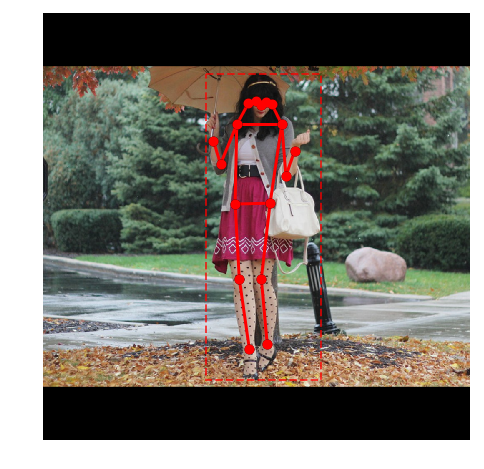

In [4]:
importlib.reload(visualize)

# Load a test image
image_id = dataset_val.image_ids[10]

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_kp_ids, gt_bbox, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, inference_config, image_id)
masks = utils.sparse_to_dense_masks(gt_kp_masks, image.shape)
    
log("image", image)
log("gt_class_ids", gt_class_ids)
log("gt_kp_ids", gt_kp_ids)
log("gt_bbox", gt_bbox)
log("gt_masks", gt_kp_masks)
log("masks", masks)

visualize.display_keypoints(image, gt_bbox, masks, gt_kp_ids,
                            skeleton=dataset_train.skeleton,
                            figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
mrcnn_mask.shape (1, 100, 17, 28, 28)
mrcnn_mask.dtype float32
detections.shape (100, 6)
mrcnn_mask.shape (100, 17, 28, 28)
masks.shape (4, 17, 28, 28)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
kp_ids                   shape: (12, 17)              min:    0.00000  max:   16.00000  int64
bbox                     shape: (4, 4)                min:    0.00000  max:  956.00000  int32
masks                    shape: (4, 17, 1024, 1024)   min:    0.00000  max:    1.00000  float64


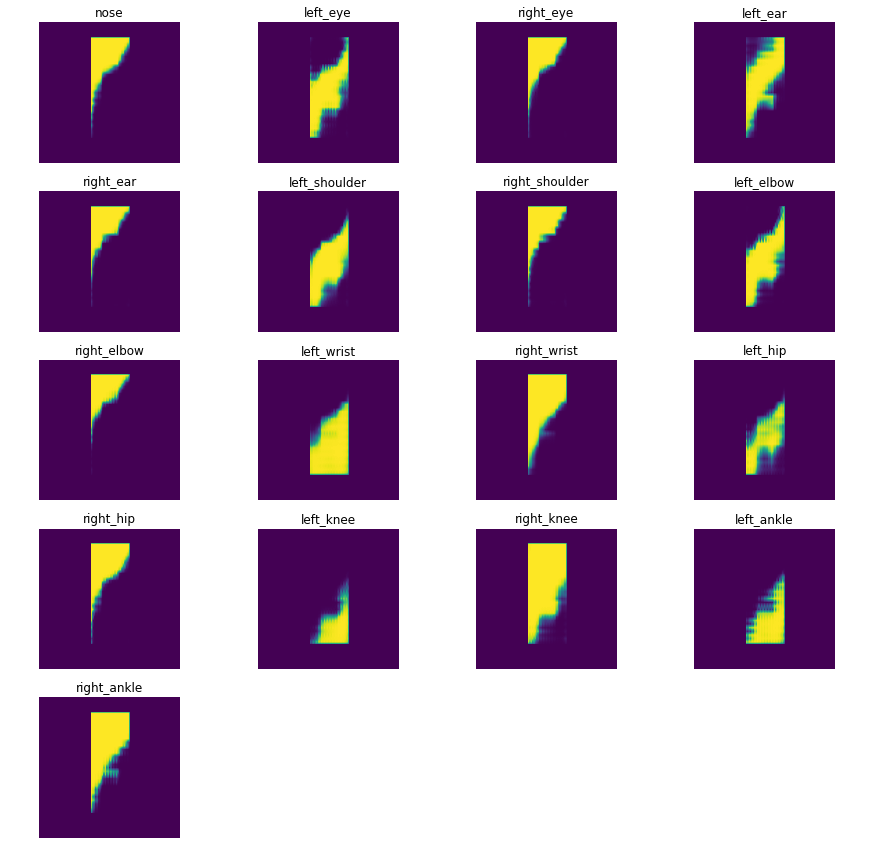

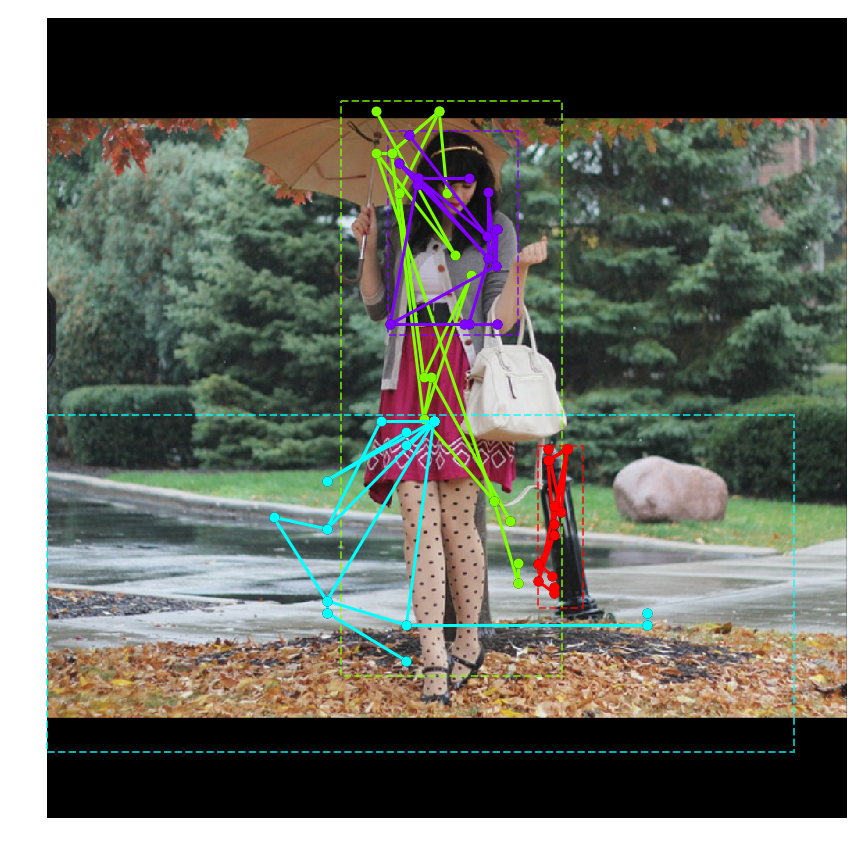

In [5]:
importlib.reload(modellib)

# Load a test image
#image_id = np.random.choice(dataset_val.image_ids)

# Get ground truth masks and bboxes
image = modellib.load_image_gt(dataset_val, inference_config, image_id)[0]

results = model.detect([image], verbose=1)
r = results[0]

bbox, kp_masks, kp_ids = r["rois"], r["masks"], np.repeat(np.expand_dims(np.arange(17), axis=0), 12, axis=0)

log("image", image)
#log("class_ids", r['class_ids'])
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", kp_masks)

%matplotlib inline
import matplotlib.pyplot as plt

n = np.sqrt(inference_config.NUM_KEYPOINTS)
_, axes = plt.subplots(int(np.ceil(n)), int(np.floor(n)), figsize=(15, 15))
if n <= 1: axes = np.array(axes)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    if i >= inference_config.NUM_KEYPOINTS: continue
    #x, y = i % 4, i // 4
    
    ax.set_title(dataset_train.kp_class_names[i+1])
    ax.imshow(kp_masks[0, i])


plt.show()

visualize.display_keypoints(image, bbox[0:5], kp_masks[0:5],
                            skeleton=dataset_train.skeleton,
                            figsize=(15, 15))